# Business Problem Statement

The Kaggle dataset represents a **general e-commerce retail model**, where churn means customers became inactive.  
In retail e-commerce, annual churn rates of **60–80%** are common ([Ecommerce Fastlane](https://ecommercefastlane.com/ecommerce-churn-rates-measure-and-reduce-lost-customers-and-revenue/?utm_source=chatgpt.com); [Sobot.io](https://www.sobot.io/article/average-churn-rate-for-ecommerce-stores-trends-2024-2025/?utm_source=chatgpt.com)).  

For this project, we **assume the dataset reflects one month of customer activity**. Under this assumption, the ~16% churn rate is far above healthy monthly benchmarks of **5–10%** seen in subscription-style e-commerce ([ScaleMath](https://scalemath.com/blog/what-is-a-good-monthly-churn-rate/?utm_source=chatgpt.com); [Opensend](https://www.opensend.com/post/churn-rate-ecommerce?utm_source=chatgpt.com)).  
This makes churn reduction a **serious business problem** and a strong candidate for predictive modeling and retention strategies.

# Evaluation Metrics

For this churn dataset, the following evaluation setup will be used:

1. **Main Metric → F2-Score**  
   - Prioritizes Recall 4× more than Precision, reflecting the fact that **acquiring a new customer is 5–25× more expensive than retaining an existing one** ([Harvard Business Review, 2014](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers?utm_source=chatgpt.com)).  
   - This makes missing churners (false negatives) far more costly than mistakenly targeting loyal customers (false positives).  
   - Supported by churn prediction literature, where Recall-oriented metrics (e.g., F2) are recommended for imbalanced datasets ([Verbeke et al., 2012](https://doi.org/10.1016/j.dss.2012.05.005)).  

2. **Supporting Metric → ROC-AUC**  
   - Evaluates model discriminative power independent of thresholds.  
   - Widely used in churn research as a benchmark for classification quality.  

3. **Supporting Tool → Classification Report**  
   - Reports Precision, Recall, and F1-score for each class.  
   - Provides transparency into trade-offs, allowing business stakeholders to see exactly how many churners are caught versus how many loyal customers are misclassified.  

**Summary:**  
- **F2-Score** will be the headline evaluation metric.  
- **ROC-AUC** provides a threshold-independent comparison across models.  
- **Classification Report** ensures interpretability and business clarity.

# Exploratory Data Analysis (EDA) on Customer Churn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load the datasets
file_path = 'E Commerce Dataset.xlsx'
df_ecommerce = pd.read_excel(file_path, sheet_name='E Comm')
df_dict = pd.read_excel(file_path, sheet_name='Data Dict')

print("Feature Descriptions:")
display(df_dict)

print("\nE-commerce Data Head:")
display(df_ecommerce.head())

Feature Descriptions:


Unnamed: 0 Unnamed: 1                   Unnamed: 2  \
0          NaN       Data                     Variable   
1          NaN     E Comm                   CustomerID   
2          NaN     E Comm                        Churn   
3          NaN     E Comm                       Tenure   
4          NaN     E Comm         PreferredLoginDevice   
5          NaN     E Comm                     CityTier   
6          NaN     E Comm              WarehouseToHome   
7          NaN     E Comm         PreferredPaymentMode   
8          NaN     E Comm                       Gender   
9          NaN     E Comm               HourSpendOnApp   
10         NaN     E Comm     NumberOfDeviceRegistered   
11         NaN     E Comm             PreferedOrderCat   
12         NaN     E Comm            SatisfactionScore   
13         NaN     E Comm                MaritalStatus   
14         NaN     E Comm              NumberOfAddress   
15         NaN     E Comm                     Complain   
16         NaN     E Comm  OrderAmountHikeFromlastYear   
17         NaN     E Comm                   CouponUsed   
18         NaN     E Comm                   OrderCount   
19         NaN     E Comm            DaySinceLastOrder   
20         NaN     E Comm               CashbackAmount   

                                           Unnamed: 3  
0                                         Discerption  
1                                  Unique customer ID  
2                                          Churn Flag  
3                  Tenure of customer in organization  
4                  Preferred login device of customer  
5                                           City tier  
6   Distance in between warehouse to home of customer  
7                Preferred payment method of customer  
8                                  Gender of customer  
9   Number of hours spend on mobile application or...  
10  Total number of deceives is registered on part...  
11  Preferred order category of customer in last m...  
12          Satisfactory score of customer on service  
13                         Marital status of customer  
14  Total number of added added on particular cust...  
15        Any complaint has been raised in last month  
16       Percentage increases in order from last year  
17  Total number of coupon has been used in last m...  
18  Total number of orders has been places in last...  
19                   Day Since last order by customer  
20                     Average cashback in last month


E-commerce Data Head:


CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1              Mobile                  3        Single                7   
2              Mobile                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4              Mobile                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

## 2. Initial Reconnaissance

In [2]:
# Check data types and look for missing values
print("Data Info:")
df_ecommerce.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberO

## 3. Descriptive Dive

In [3]:
# Calculate key statistics
print("Descriptive Statistics:")
display(df_ecommerce.describe())

Descriptive Statistics:


CustomerID        Churn       Tenure     CityTier  WarehouseToHome  \
count   5630.000000  5630.000000  5366.000000  5630.000000      5379.000000   
mean   52815.500000     0.168384    10.189899     1.654707        15.639896   
std     1625.385339     0.374240     8.557241     0.915389         8.531475   
min    50001.000000     0.000000     0.000000     1.000000         5.000000   
25%    51408.250000     0.000000     2.000000     1.000000         9.000000   
50%    52815.500000     0.000000     9.000000     1.000000        14.000000   
75%    54222.750000     0.000000    16.000000     3.000000        20.000000   
max    55630.000000     1.000000    61.000000     3.000000       127.000000   

       HourSpendOnApp  NumberOfDeviceRegistered  SatisfactionScore  \
count     5375.000000               5630.000000        5630.000000   
mean         2.931535                  3.688988           3.066785   
std          0.721926                  1.023999           1.380194   
min          0.000000                  1.000000           1.000000   
25%          2.000000                  3.000000           2.000000   
50%          3.000000                  4.000000           3.000000   
75%          3.000000                  4.000000           4.000000   
max          5.000000                  6.000000           5.000000   

       NumberOfAddress     Complain  OrderAmountHikeFromlastYear   CouponUsed  \
count      5630.000000  5630.000000                  5365.000000  5374.000000   
mean          4.214032     0.284902                    15.707922     1.751023   
std           2.583586     0.451408                     3.675485     1.894621   
min           1.000000     0.000000                    11.000000     0.000000   
25%           2.000000     0.000000                    13.000000     1.000000   
50%           3.000000     0.000000                    15.000000     1.000000   
75%           6.000000     1.000000                    18.000000     2.000000   
max          22.000000     1.000000                    26.000000    16.000000   

        OrderCount  DaySinceLastOrder  CashbackAmount  
count  5372.000000        5323.000000     5630.000000  
mean      3.008004           4.543491      177.223030  
std       2.939680           3.654433       49.207036  
min       1.000000           0.000000        0.000000  
25%       1.000000           2.000000      145.770000  
50%       2.000000           3.000000      163.280000  
75%       3.000000           7.000000      196.392500  
max      16.000000          46.000000      324.990000

## 4. Clean Up Crew

In [4]:
# Standardize payment mode values
df_ecommerce['PreferredPaymentMode'] = df_ecommerce['PreferredPaymentMode'].replace({'CC': 'Credit Card', 'COD': 'Cash on Delivery'})

# Standardize login device
df_ecommerce['PreferredLoginDevice'] = df_ecommerce['PreferredLoginDevice'].replace({'Phone': 'Mobile Phone'})

# Standardize order category
df_ecommerce['PreferedOrderCat'] = df_ecommerce['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'})

print("Cleaned Data Checks:")
print('Unique Payment Modes:', df_ecommerce['PreferredPaymentMode'].unique())
print('Unique Login Devices:', df_ecommerce['PreferredLoginDevice'].unique())
print('Unique Order Categories:', df_ecommerce['PreferedOrderCat'].unique())
print('Max WarehouseToHome:', df_ecommerce['WarehouseToHome'].max())

Cleaned Data Checks:
Unique Payment Modes: ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
Unique Login Devices: ['Mobile Phone' 'Computer']
Unique Order Categories: ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
Max WarehouseToHome: 127.0


## 5. In-Depth Numerical Analysis

### 5.1. Univariate Numerical Analysis

Analyzing Numerical Feature: Tenure


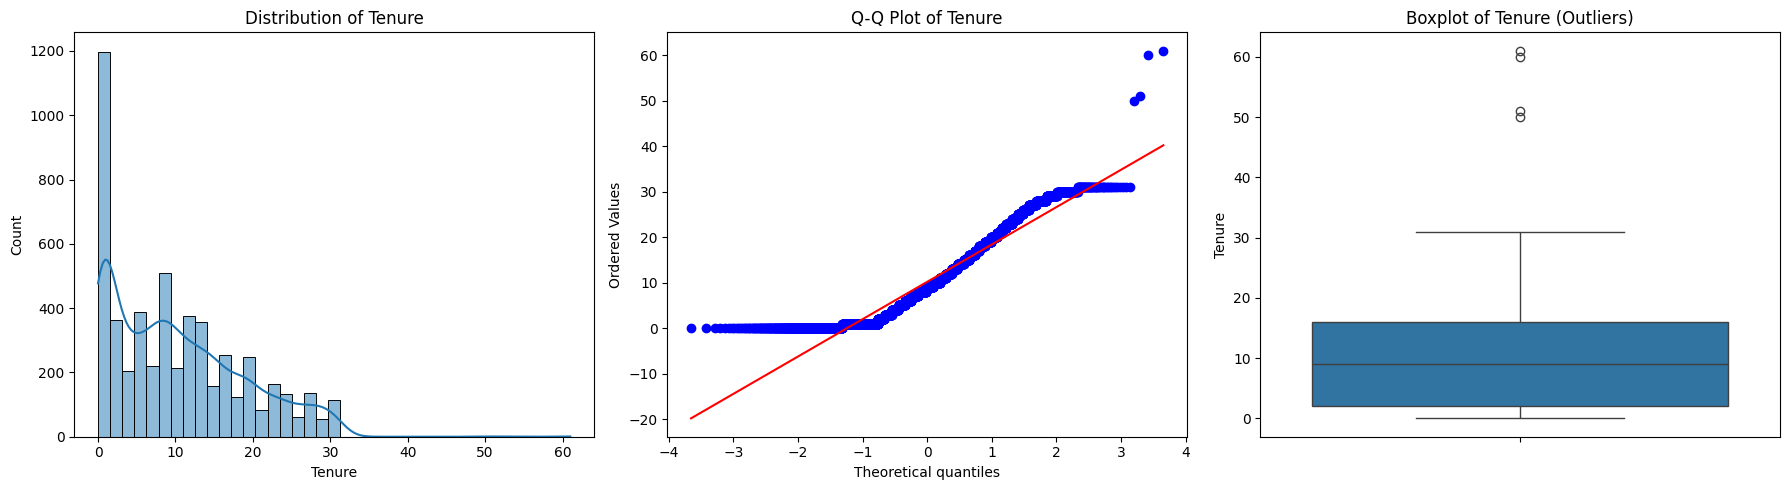

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5366.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for Tenure: Statistics=0.920, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: WarehouseToHome


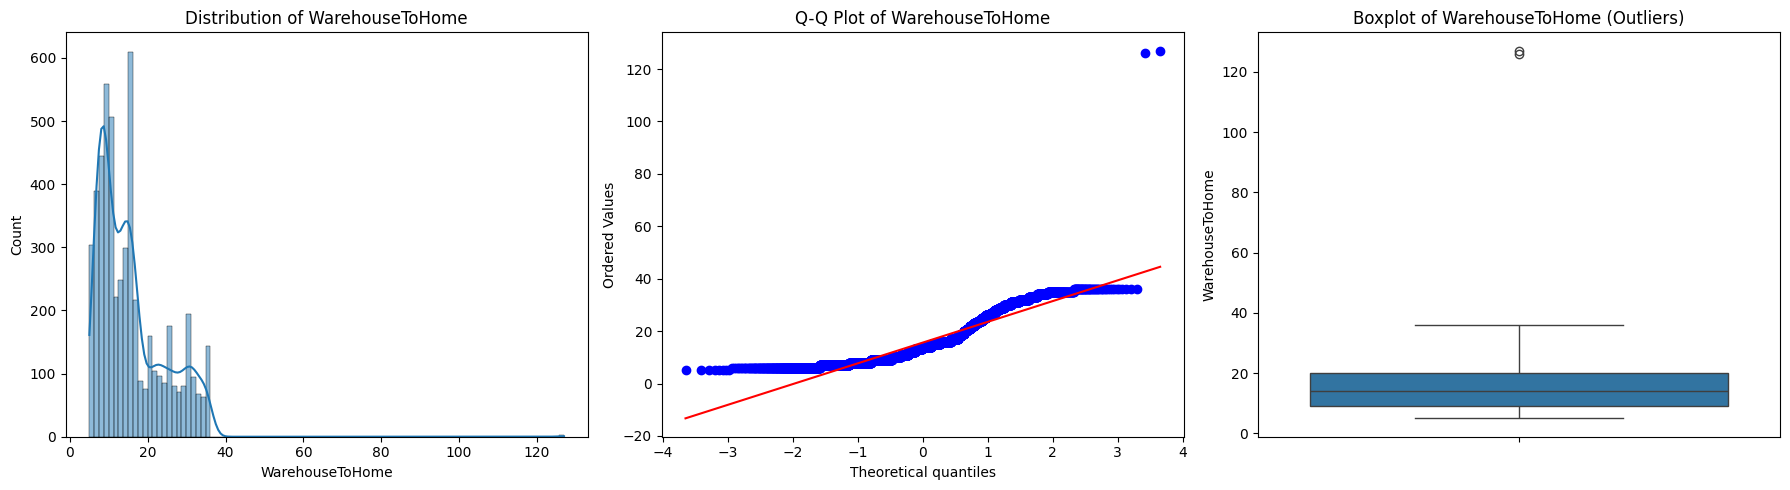

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5379.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for WarehouseToHome: Statistics=0.860, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: HourSpendOnApp


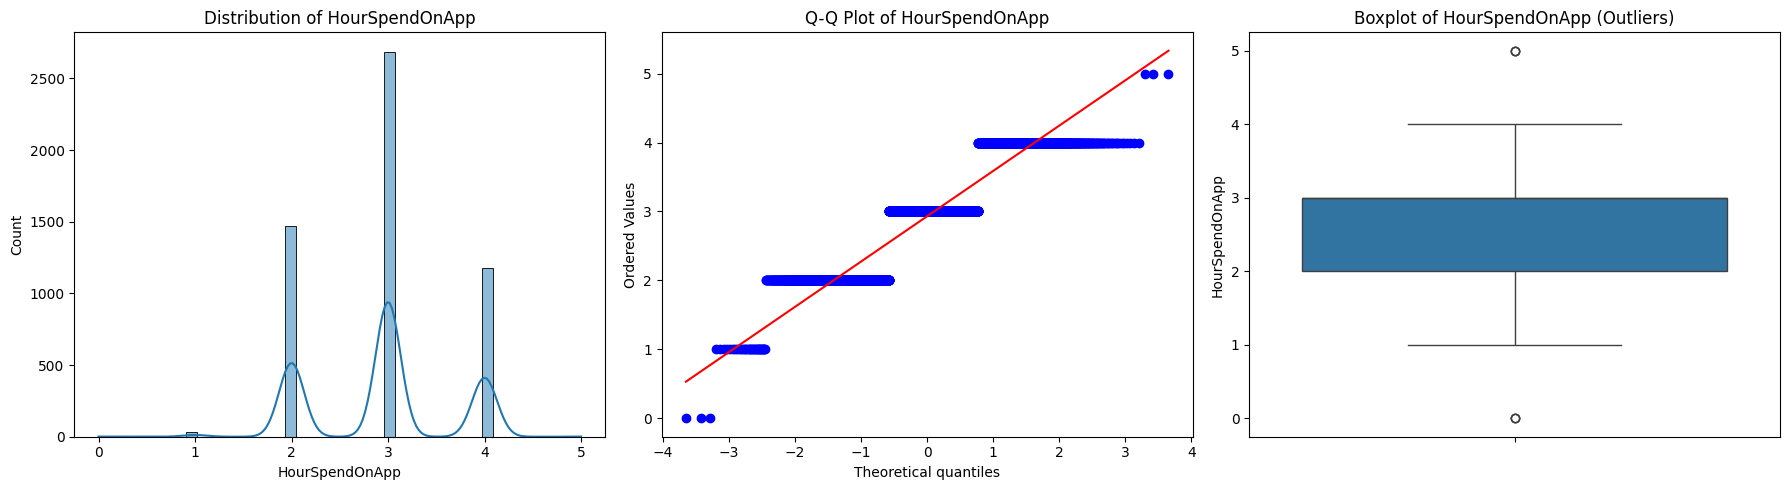

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5375.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for HourSpendOnApp: Statistics=0.827, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: NumberOfDeviceRegistered


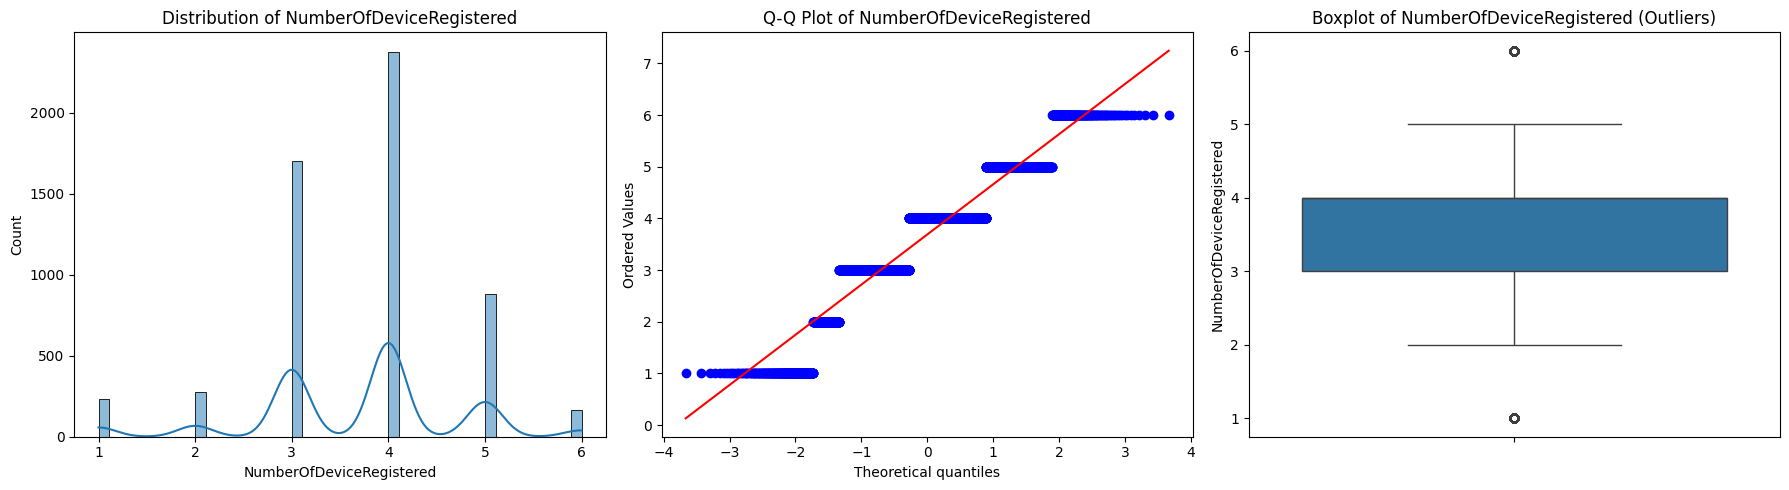

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for NumberOfDeviceRegistered: Statistics=0.897, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: NumberOfAddress


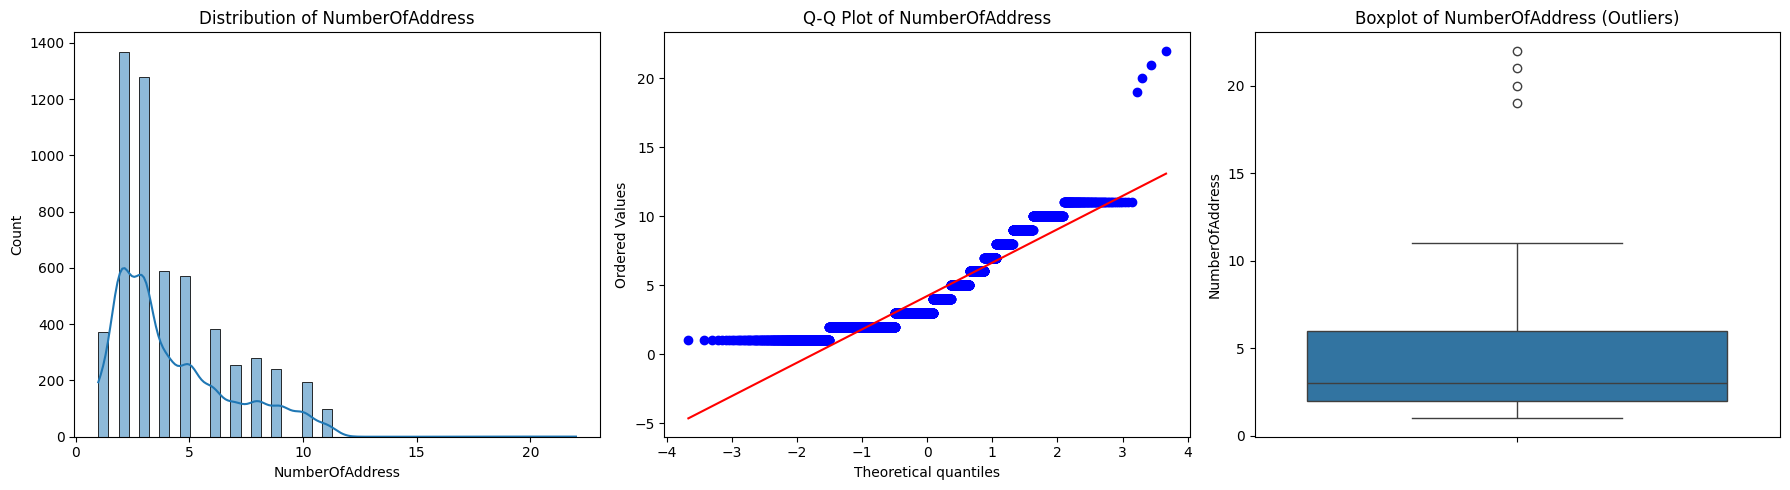

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for NumberOfAddress: Statistics=0.877, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: OrderAmountHikeFromlastYear


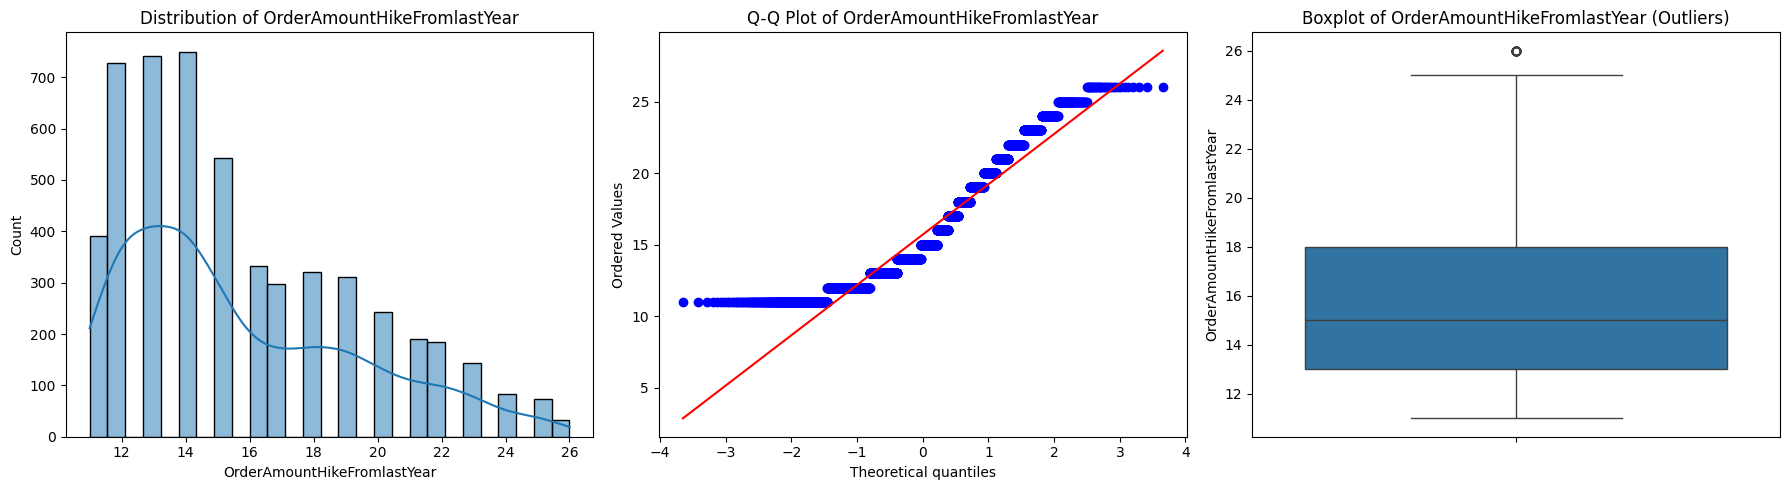

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5365.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for OrderAmountHikeFromlastYear: Statistics=0.915, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: CouponUsed


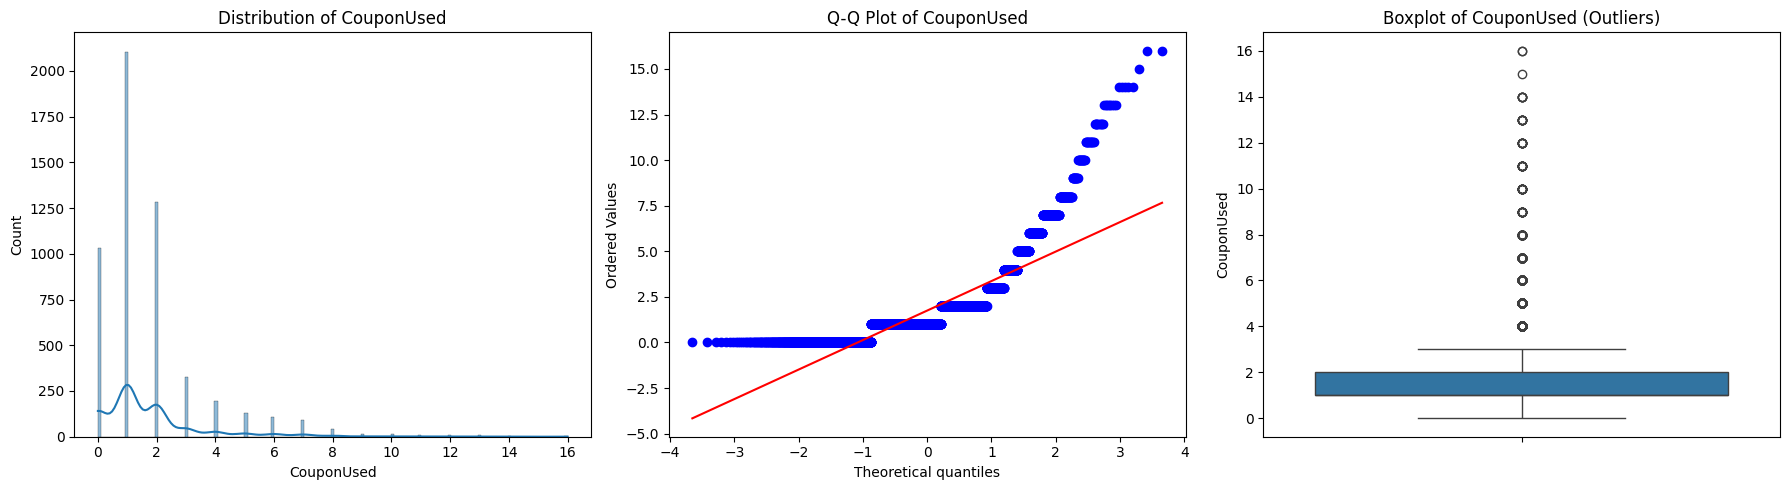

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5374.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for CouponUsed: Statistics=0.728, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: OrderCount


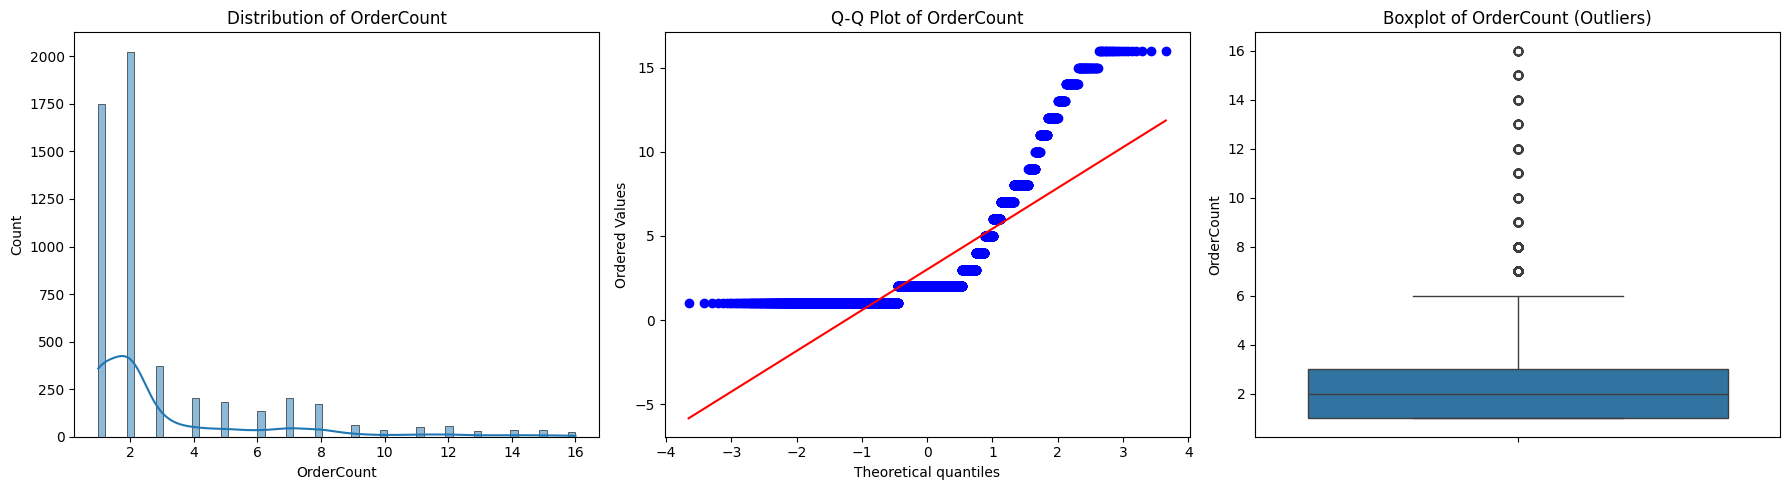

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5372.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for OrderCount: Statistics=0.677, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: DaySinceLastOrder


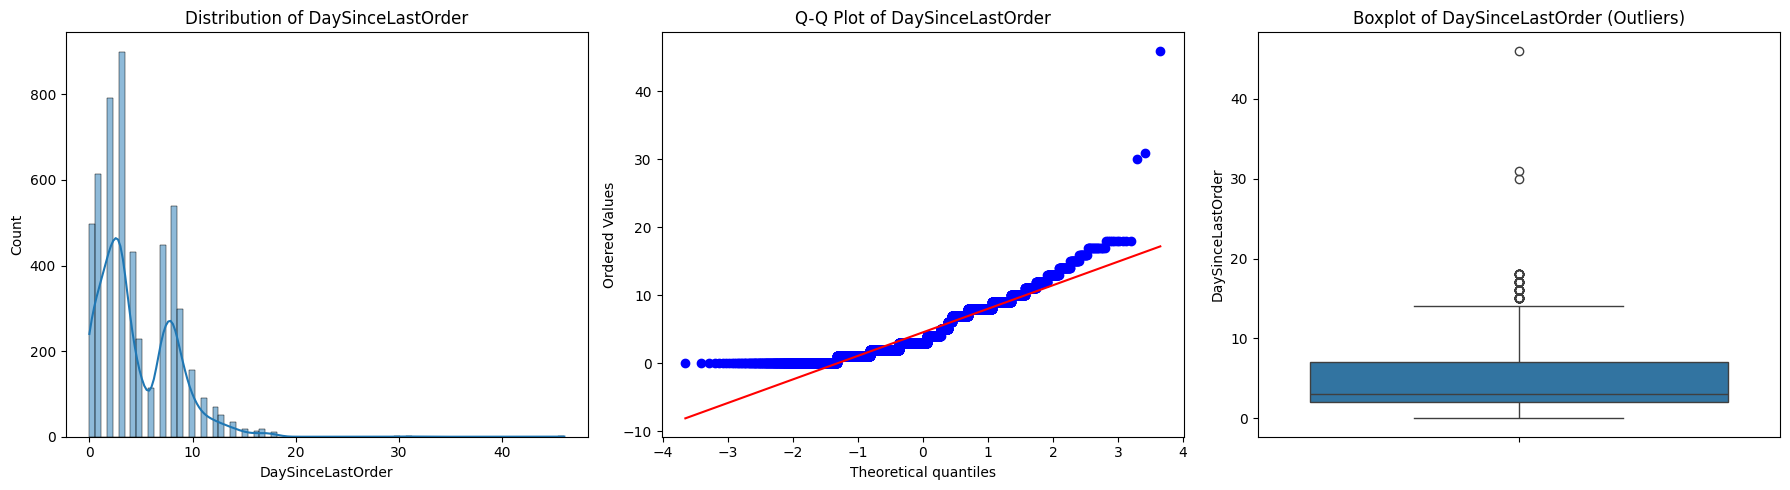

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5323.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for DaySinceLastOrder: Statistics=0.899, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: CashbackAmount


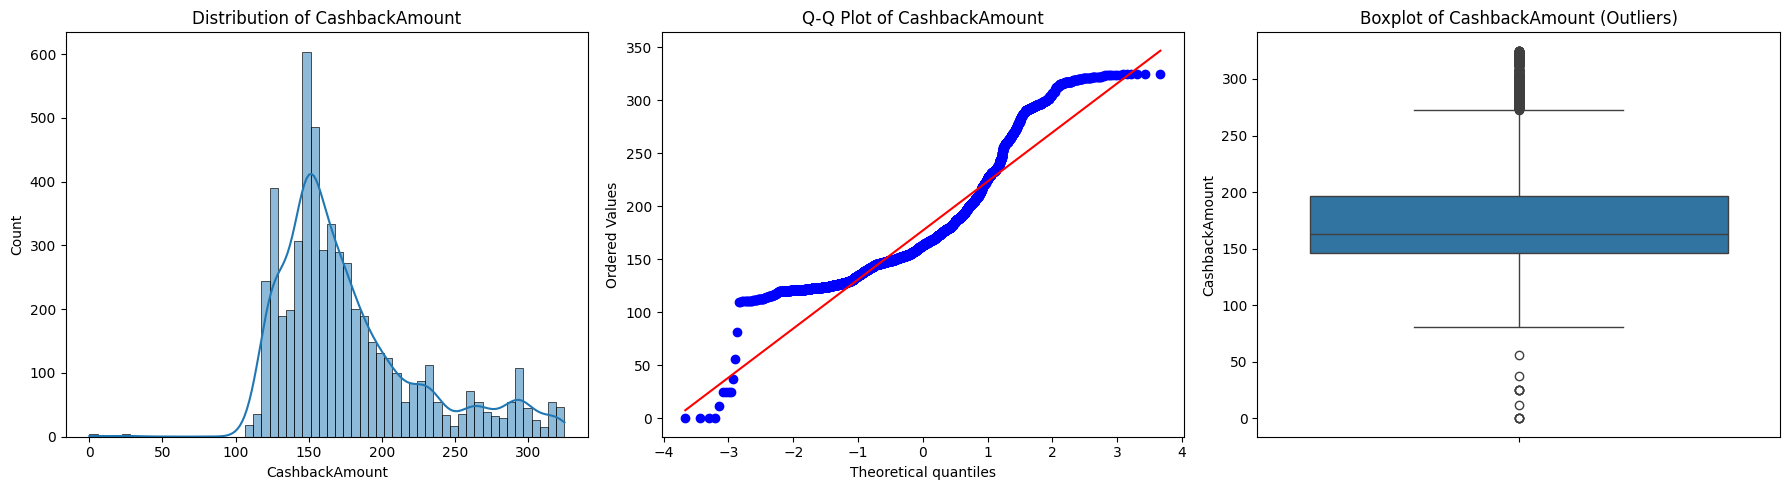

Shapiro-Wilk Test for CashbackAmount: Statistics=0.883, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------



/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming your DataFrame is named 'df_ecommerce'.
# Make sure to load your data into this DataFrame before running the code.
# Example: df_ecommerce = pd.read_csv('your_data_file.csv')

numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

for col in numerical_features:
    print(f'Analyzing Numerical Feature: {col}')
    
    # Distribution, Normality, and Outlier Check
    plt.figure(figsize=(18, 5)) # Increased figure size to accommodate 3 plots
    
    # Histogram
    plt.subplot(1, 3, 1) # Changed to 1 row, 3 columns
    sns.histplot(df_ecommerce[col], kde=True)
    plt.title(f'Distribution of {col}')
    
    # Q-Q Plot
    plt.subplot(1, 3, 2) # Changed to 1 row, 3 columns
    stats.probplot(df_ecommerce[col].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')

    # Boxplot for Outliers
    plt.subplot(1, 3, 3) # Added a third subplot
    sns.boxplot(y=df_ecommerce[col])
    plt.title(f'Boxplot of {col} (Outliers)')
    
    plt.tight_layout()
    plt.show() # Display the plot directly
    
    # Shapiro-Wilk Test
    stat, p = stats.shapiro(df_ecommerce[col].dropna())
    print(f'Shapiro-Wilk Test for {col}: Statistics={stat:.3f}, p-value={p:.3f}')
    
    if p > 0.05:
        print('Conclusion: Sample looks Gaussian (fail to reject H0).')
        normality = True
    else:
        print('Conclusion: Sample does not look Gaussian (reject H0).')
        normality = False
    
    print('\n' + '-'*50 + '\n')

### 5.2. Bivariate Numerical Analysis

Analyzing Tenure by Churn


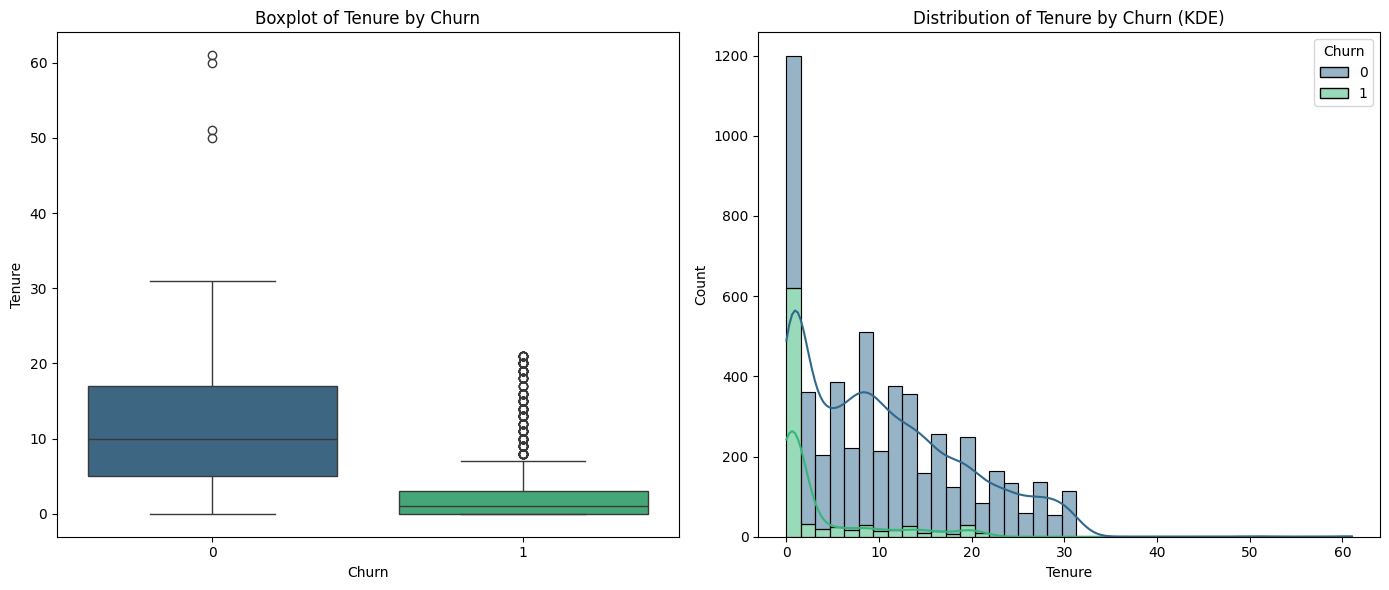

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5366.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for Tenure: U-statistic=714994.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing WarehouseToHome by Churn


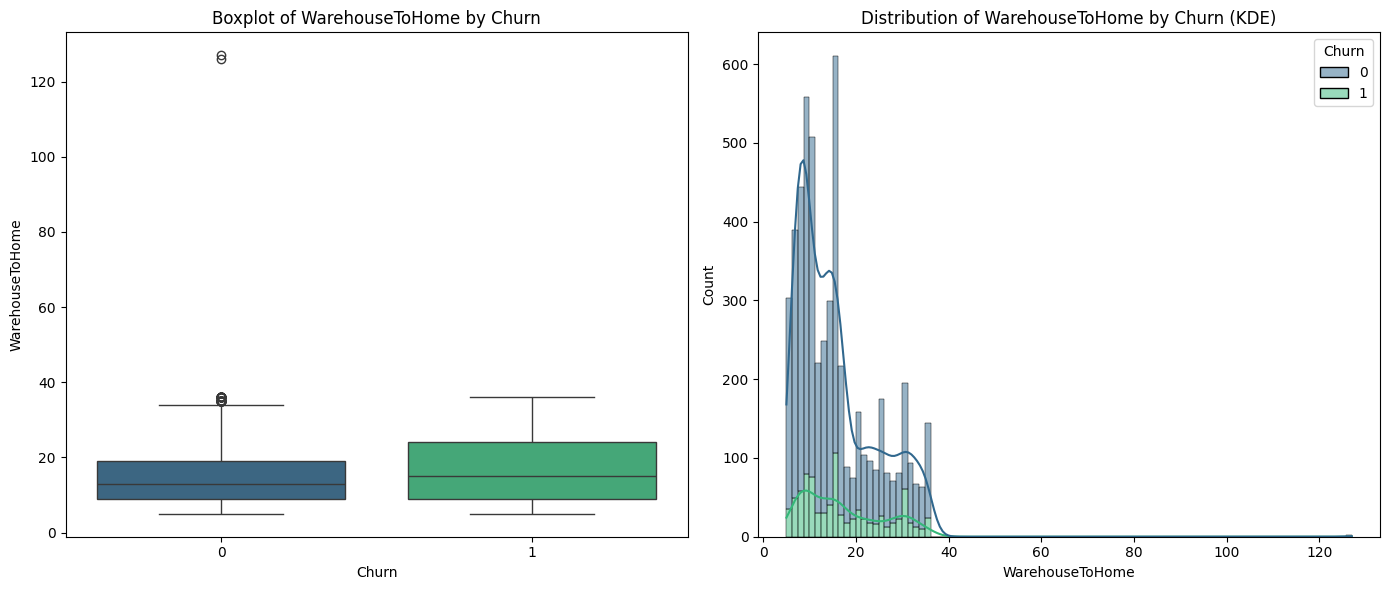

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5379.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for WarehouseToHome: U-statistic=2198913.500, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing HourSpendOnApp by Churn


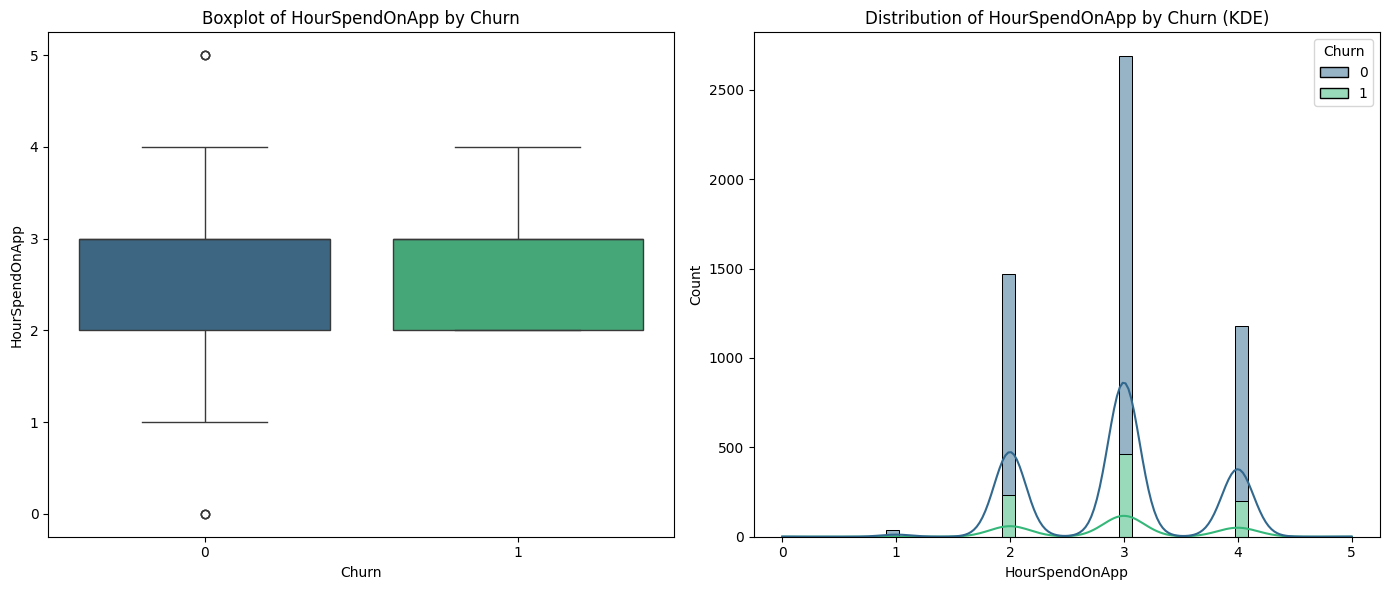

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5375.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for HourSpendOnApp: U-statistic=2042784.000, p-value=0.227
Conclusion: There is no significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing NumberOfDeviceRegistered by Churn


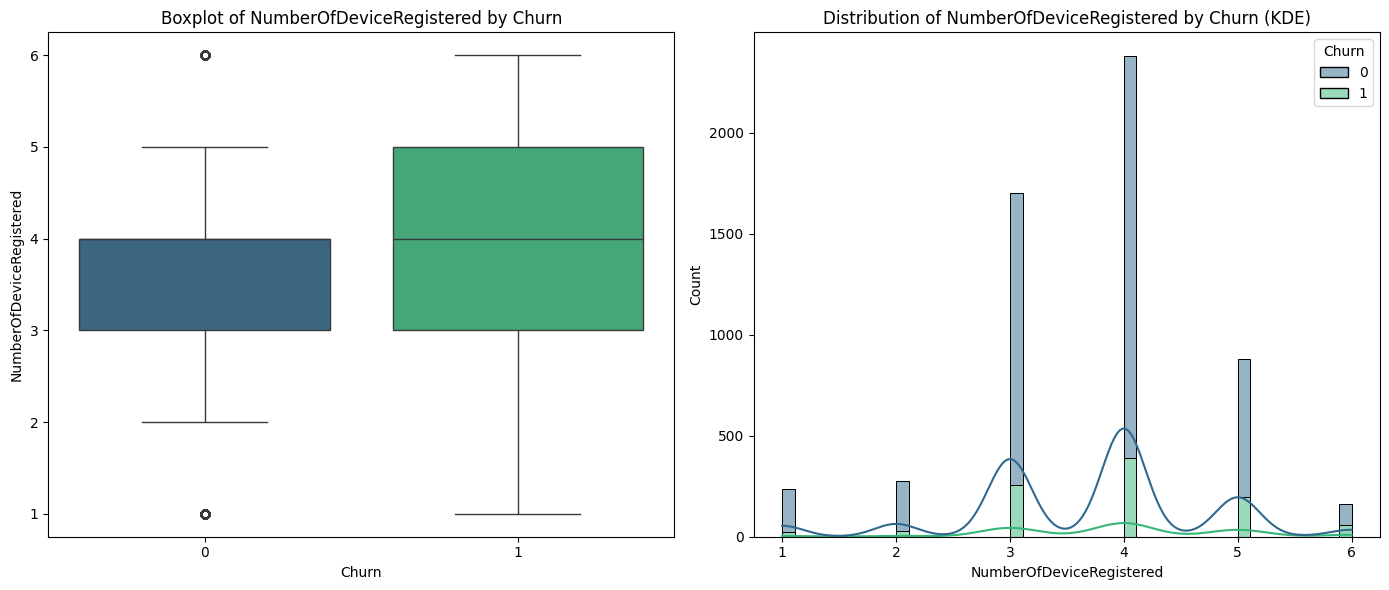

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for NumberOfDeviceRegistered: U-statistic=2546899.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing NumberOfAddress by Churn


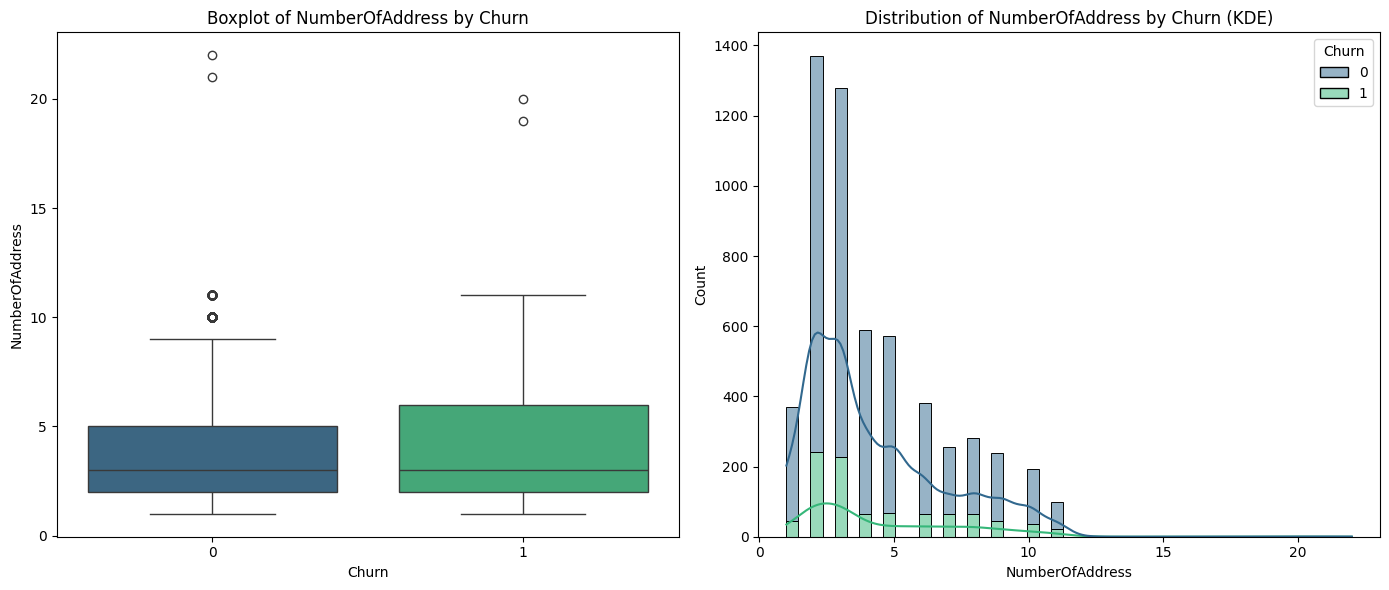

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for NumberOfAddress: U-statistic=2316556.500, p-value=0.030
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing OrderAmountHikeFromlastYear by Churn


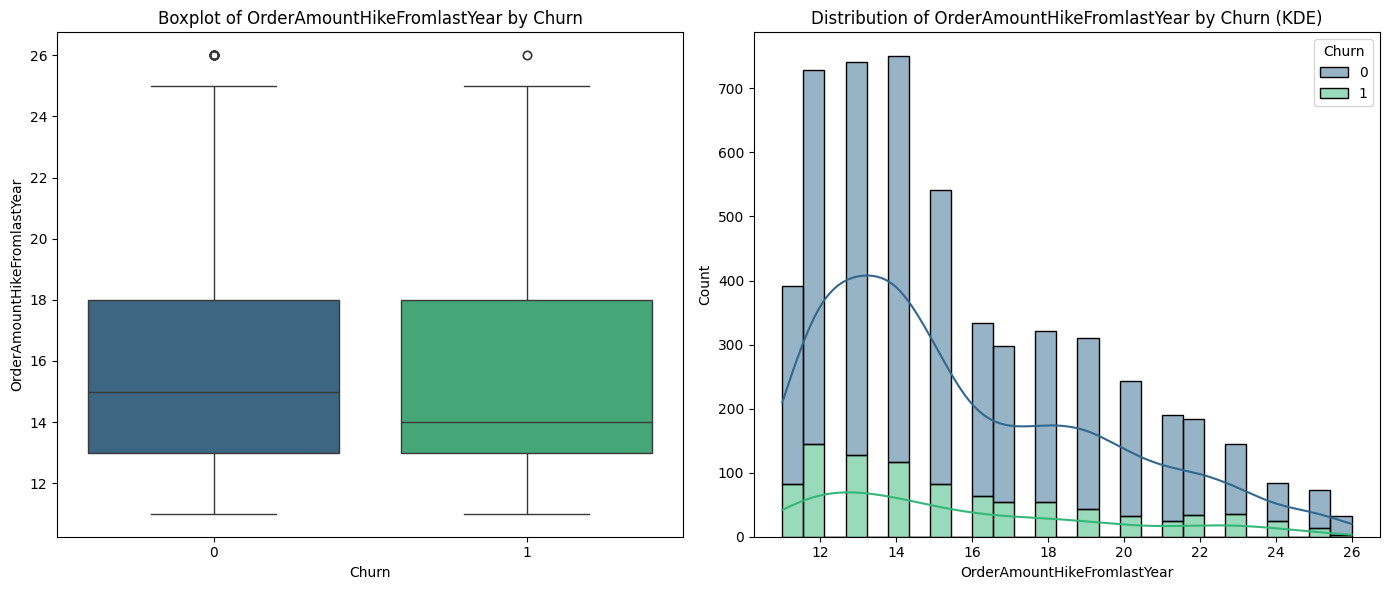

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5365.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for OrderAmountHikeFromlastYear: U-statistic=2004453.000, p-value=0.130
Conclusion: There is no significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing CouponUsed by Churn


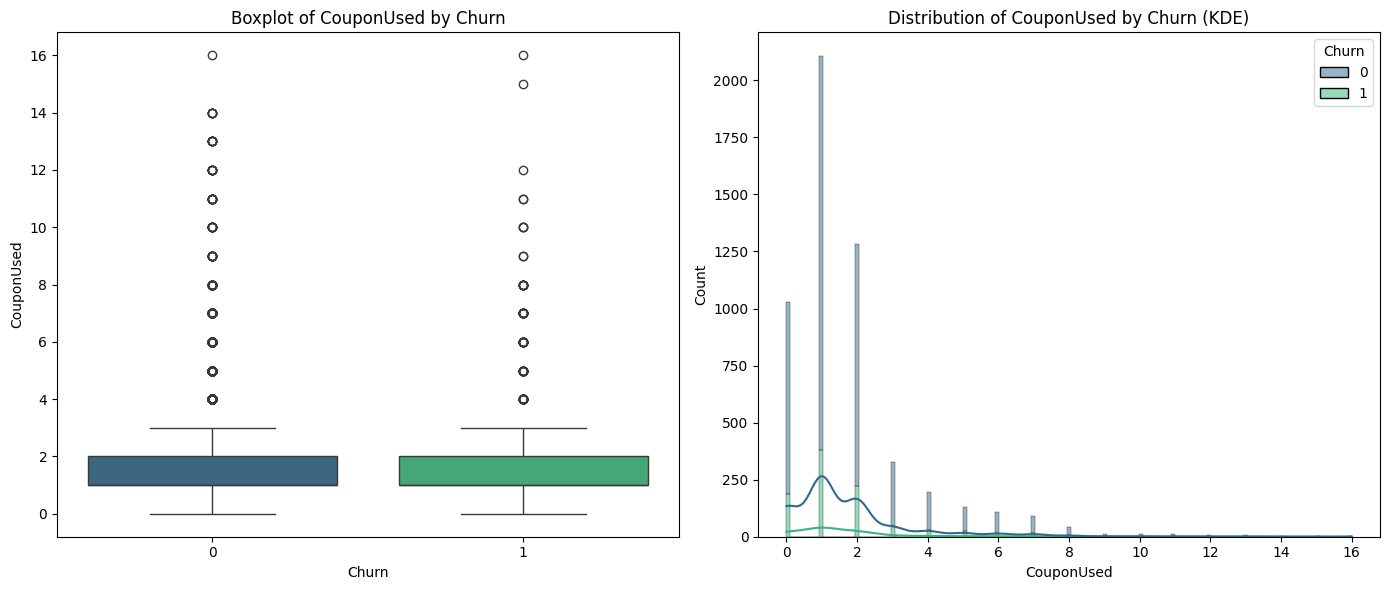

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5374.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for CouponUsed: U-statistic=2038042.500, p-value=0.267
Conclusion: There is no significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing OrderCount by Churn


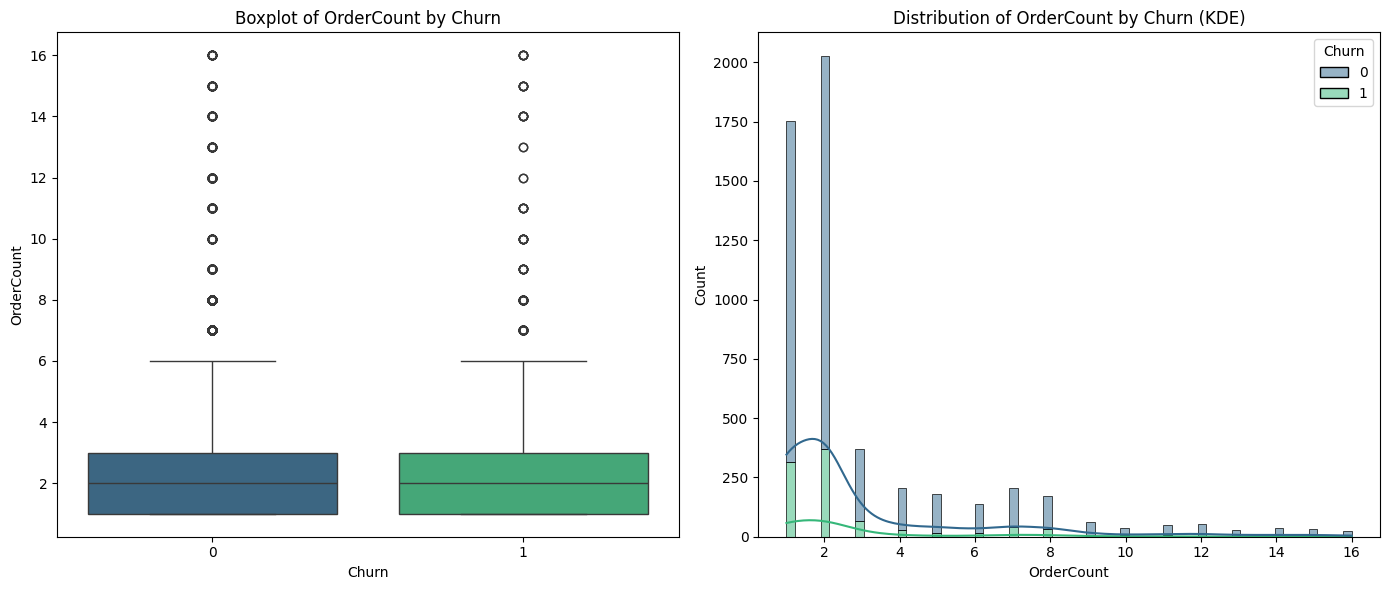

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5372.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for OrderCount: U-statistic=1979607.000, p-value=0.036
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing DaySinceLastOrder by Churn


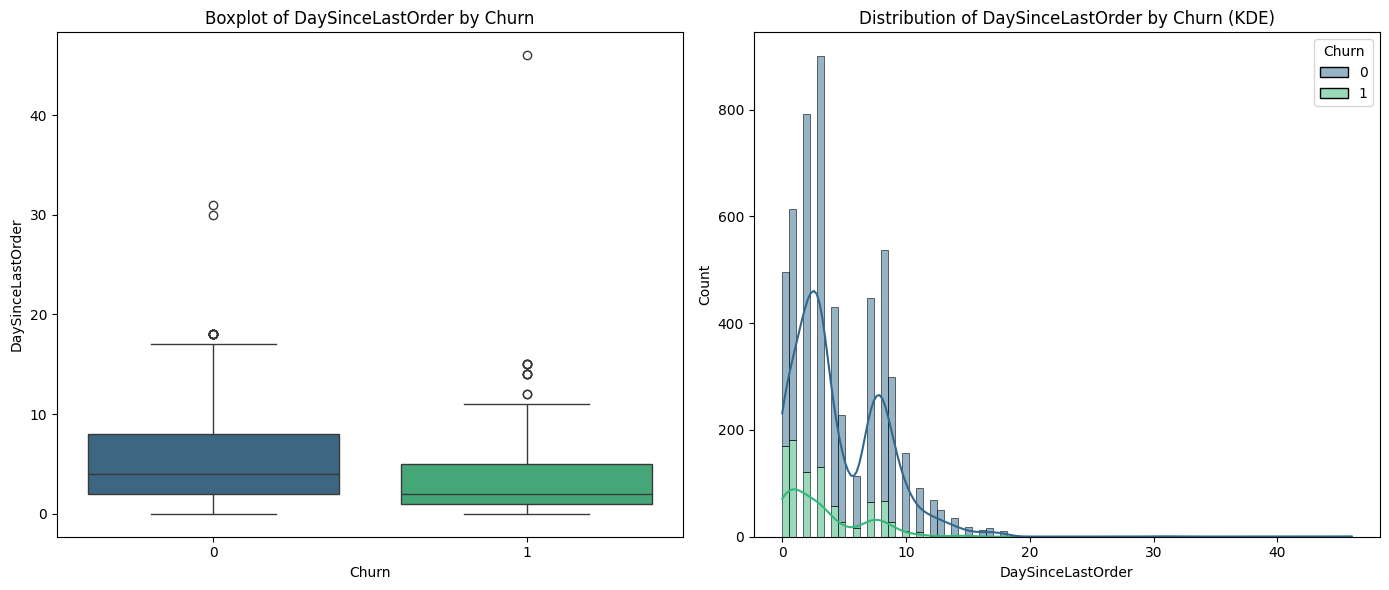

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5323.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for DaySinceLastOrder: U-statistic=1412515.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing CashbackAmount by Churn


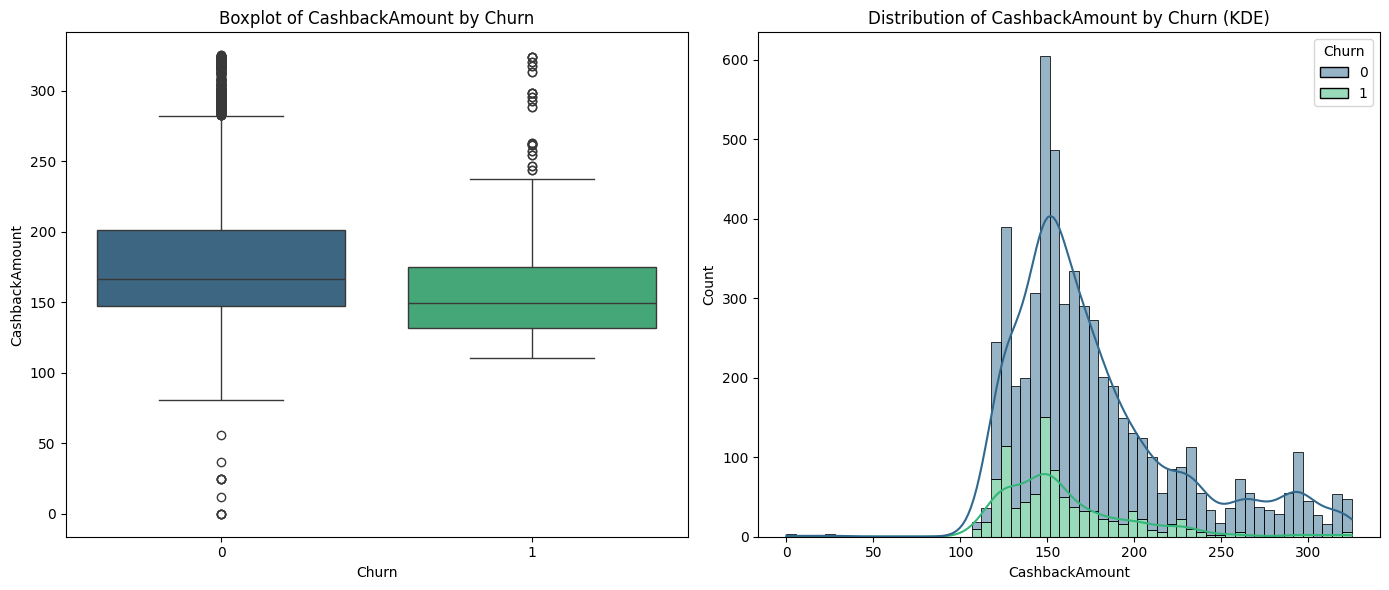

Mann-Whitney U test for CashbackAmount: U-statistic=1628505.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------



/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming your DataFrame is named 'df_ecommerce'.
# Make sure to load your data into this DataFrame before running the code.
# Example: df_ecommerce = pd.read_csv('your_data_file.csv')

numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

for col in numerical_features:
    print(f'Analyzing {col} by Churn')
    
    plt.figure(figsize=(14, 6)) # Adjust figure size for two plots

    # Boxplot by Churn with distinct colors
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Churn', y=col, data=df_ecommerce, hue='Churn', palette='viridis', legend=False) # Added hue='Churn' and palette
    plt.title(f'Boxplot of {col} by Churn')
    
    # Histplot with KDE by Churn
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_ecommerce, x=col, hue='Churn', kde=True, palette='viridis', multiple="stack") # Added hue='Churn' and kde=True
    plt.title(f'Distribution of {col} by Churn (KDE)')
    
    plt.tight_layout()
    plt.show() # Display the plot directly
    
    # Prepare data for statistical tests
    churn_yes = df_ecommerce[df_ecommerce['Churn'] == 1][col].dropna()
    churn_no = df_ecommerce[df_ecommerce['Churn'] == 0][col].dropna()
    
    # Determine normality from the univariate analysis (assuming it was run)
    # If you run these cells independently, you might need to re-calculate normality here.
    # For now, let's include a quick check or assume 'normality' is passed from Cell 1 if run sequentially.
    # For robust independent execution, uncomment the following line:
    _, p_shapiro = stats.shapiro(df_ecommerce[col].dropna())
    normality = p_shapiro > 0.05
    
    if normality:
        t_stat, t_p = stats.ttest_ind(churn_yes, churn_no)
        print(f'Independent T-test for {col}: T-statistic={t_stat:.3f}, p-value={t_p:.3f}')
        if t_p < 0.05:
            print('Conclusion: There is a significant difference in means between churn groups.')
        else:
            print('Conclusion: There is no significant difference in means between churn groups.')
    else:
        u_stat, u_p = stats.mannwhitneyu(churn_yes, churn_no)
        print(f'Mann-Whitney U test for {col}: U-statistic={u_stat:.3f}, p-value={u_p:.3f}')
        if u_p < 0.05:
            print('Conclusion: There is a significant difference in distributions between churn groups.')
        else:
            print('Conclusion: There is no significant difference in distributions between churn groups.')
            
    print('\n' + '-'*50 + '\n')

Analyzing Numerical Feature: Tenure


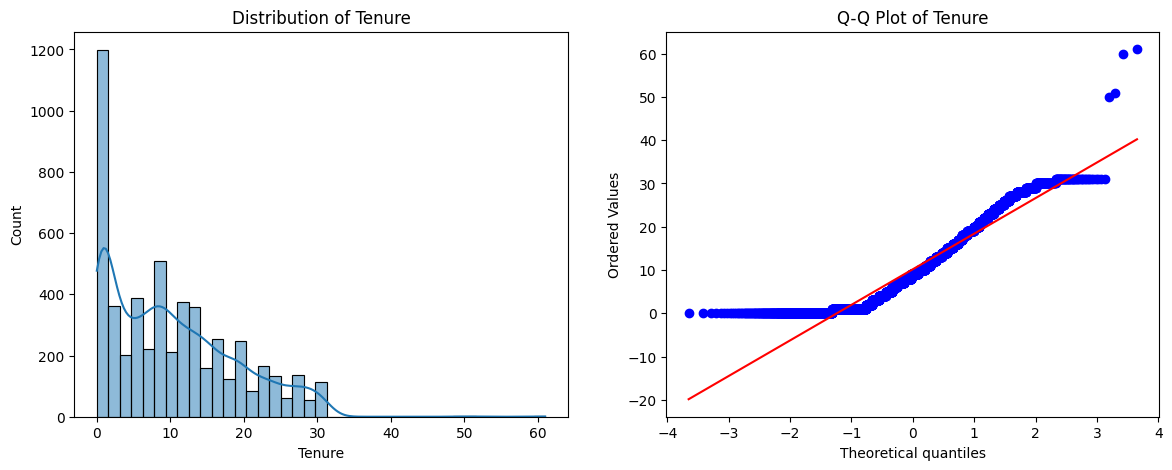

Shapiro-Wilk Test for Tenure: Statistics=0.920, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5366.
  res = hypotest_fun_out(*samples, **kwds)


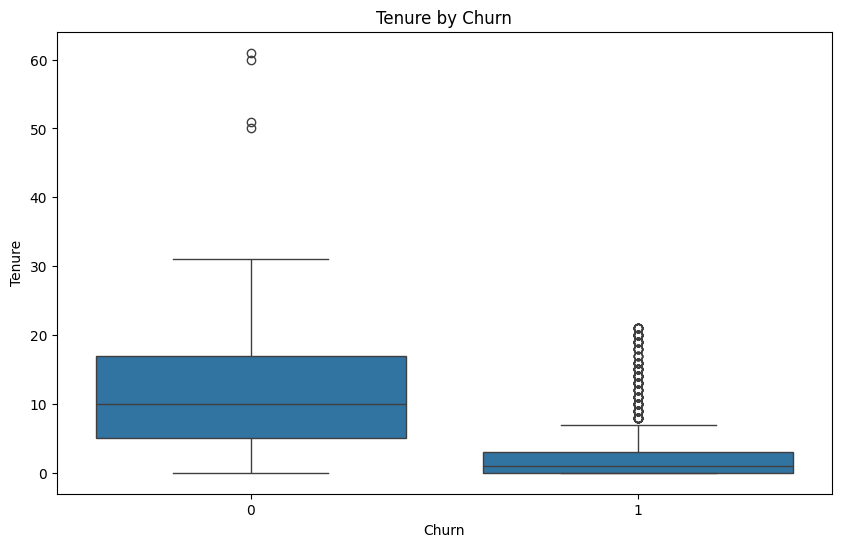

Mann-Whitney U test for Tenure: U-statistic=714994.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing Numerical Feature: WarehouseToHome


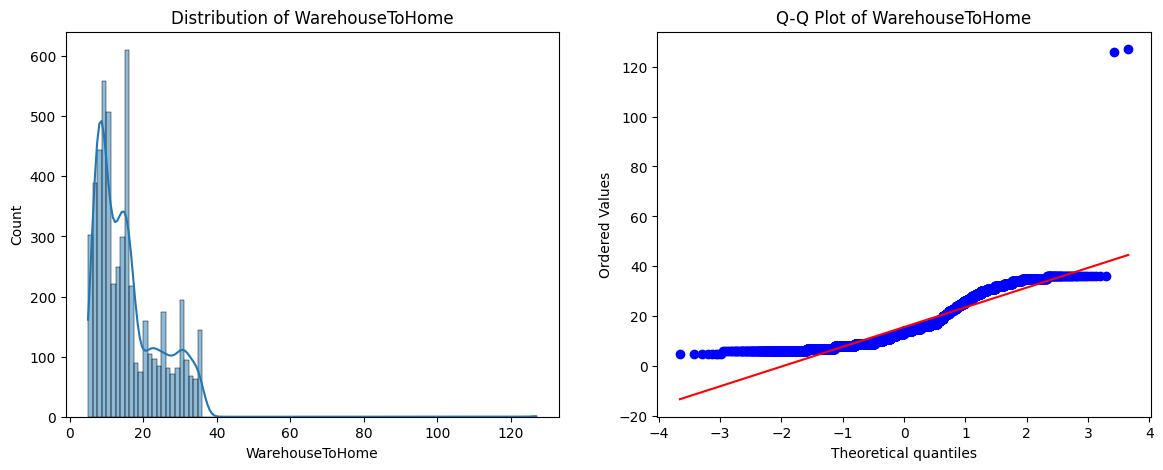

Shapiro-Wilk Test for WarehouseToHome: Statistics=0.860, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5379.
  res = hypotest_fun_out(*samples, **kwds)


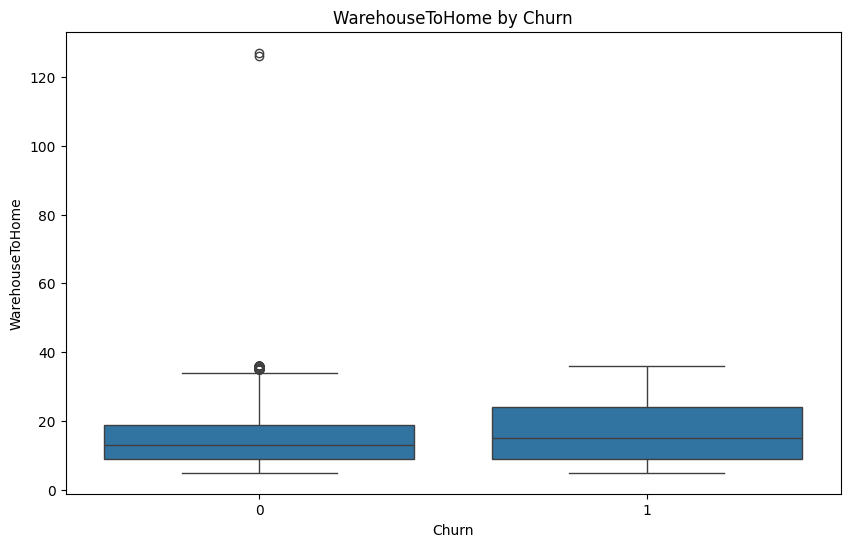

Mann-Whitney U test for WarehouseToHome: U-statistic=2198913.500, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing Numerical Feature: HourSpendOnApp


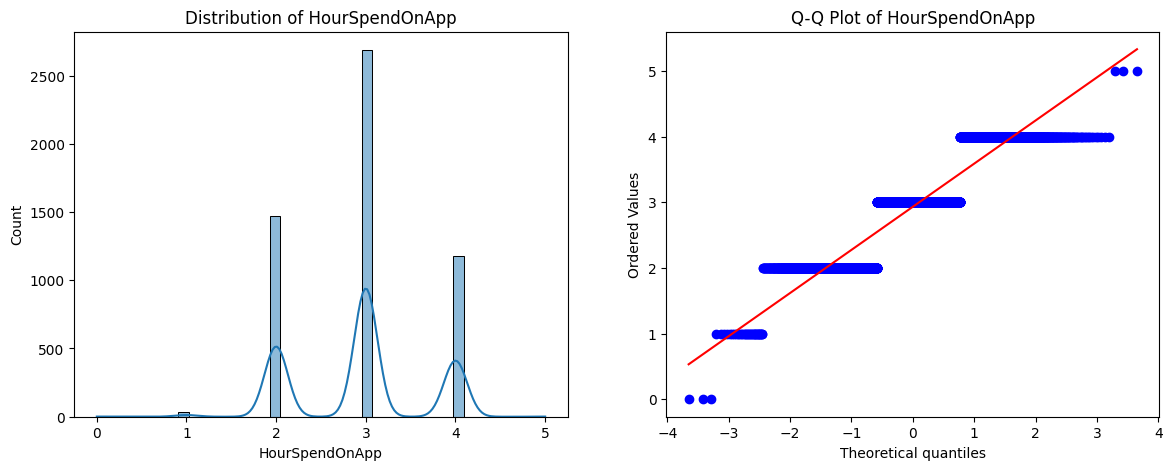

Shapiro-Wilk Test for HourSpendOnApp: Statistics=0.827, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5375.
  res = hypotest_fun_out(*samples, **kwds)


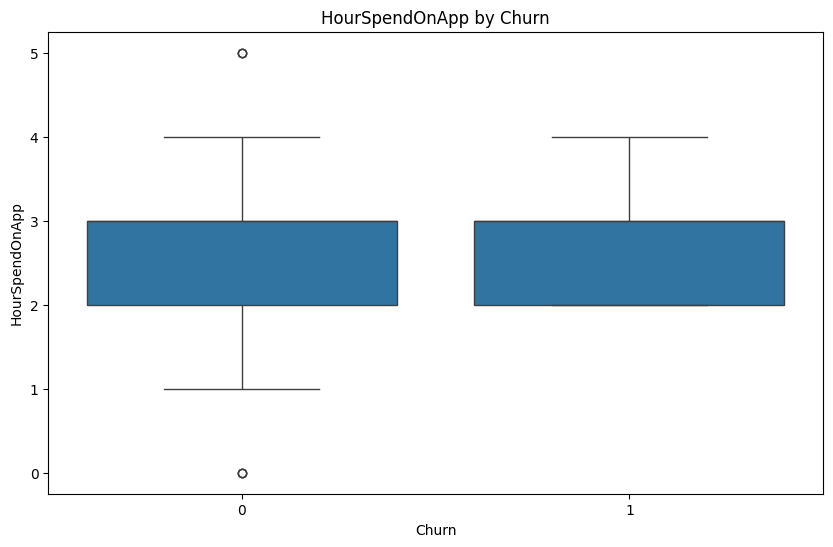

Mann-Whitney U test for HourSpendOnApp: U-statistic=2042784.000, p-value=0.227
Conclusion: There is no significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing Numerical Feature: NumberOfDeviceRegistered


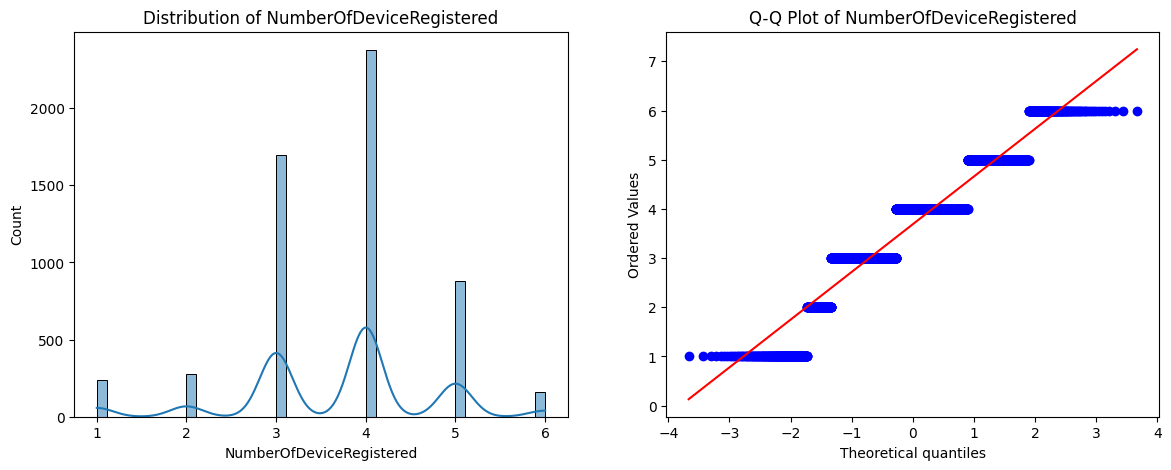

Shapiro-Wilk Test for NumberOfDeviceRegistered: Statistics=0.897, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


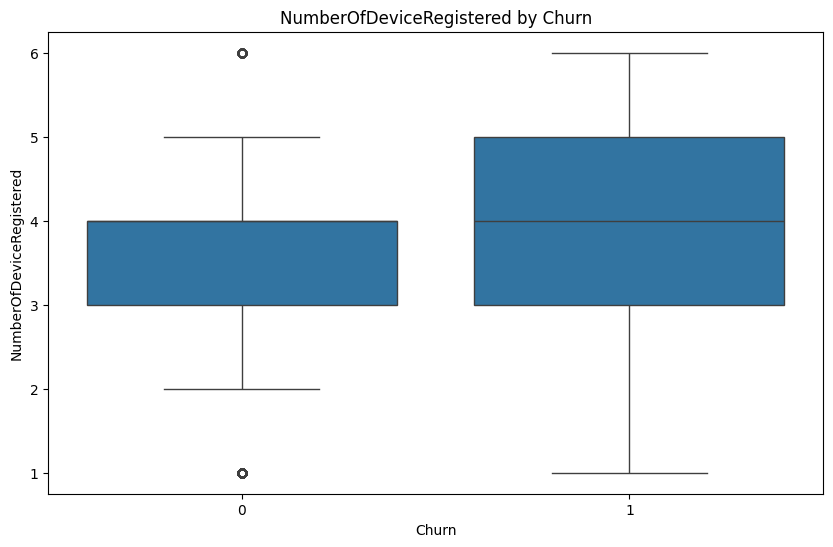

Mann-Whitney U test for NumberOfDeviceRegistered: U-statistic=2546899.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing Numerical Feature: NumberOfAddress


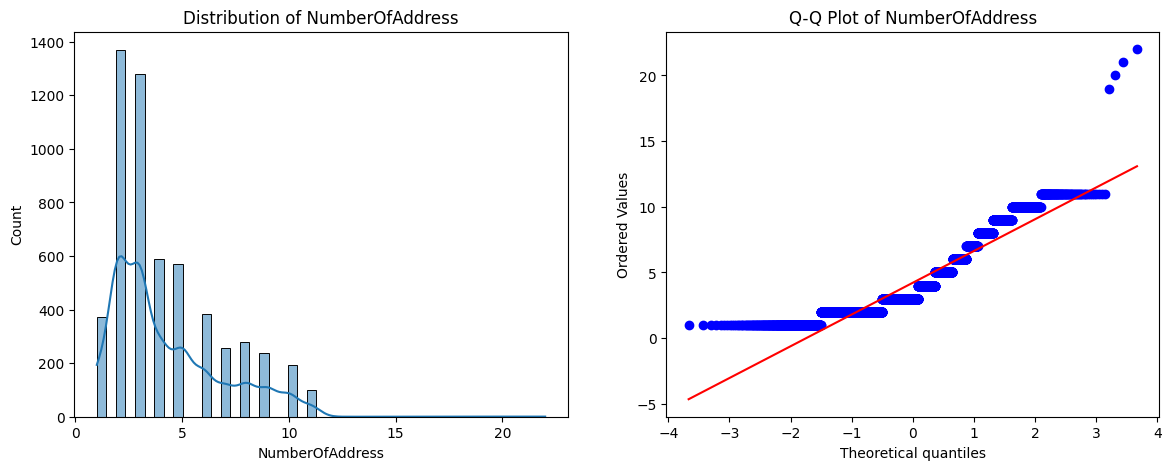

Shapiro-Wilk Test for NumberOfAddress: Statistics=0.877, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


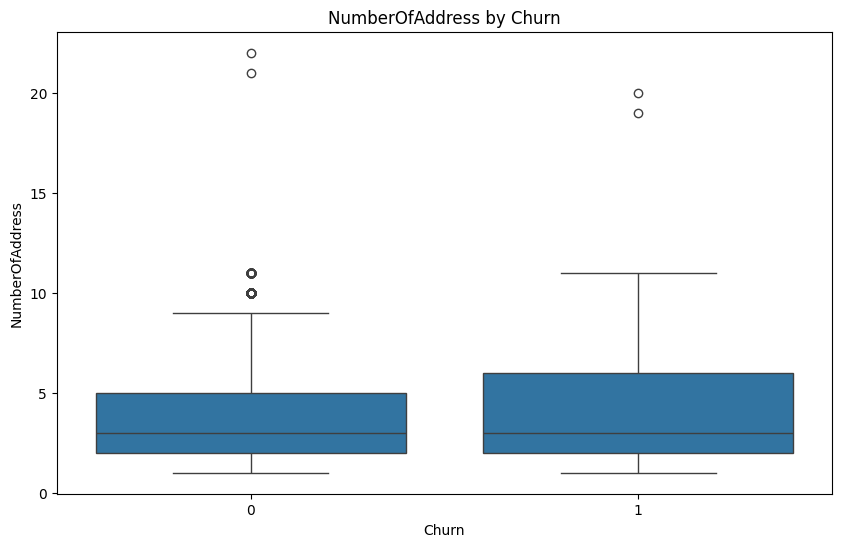

Mann-Whitney U test for NumberOfAddress: U-statistic=2316556.500, p-value=0.030
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing Numerical Feature: OrderAmountHikeFromlastYear


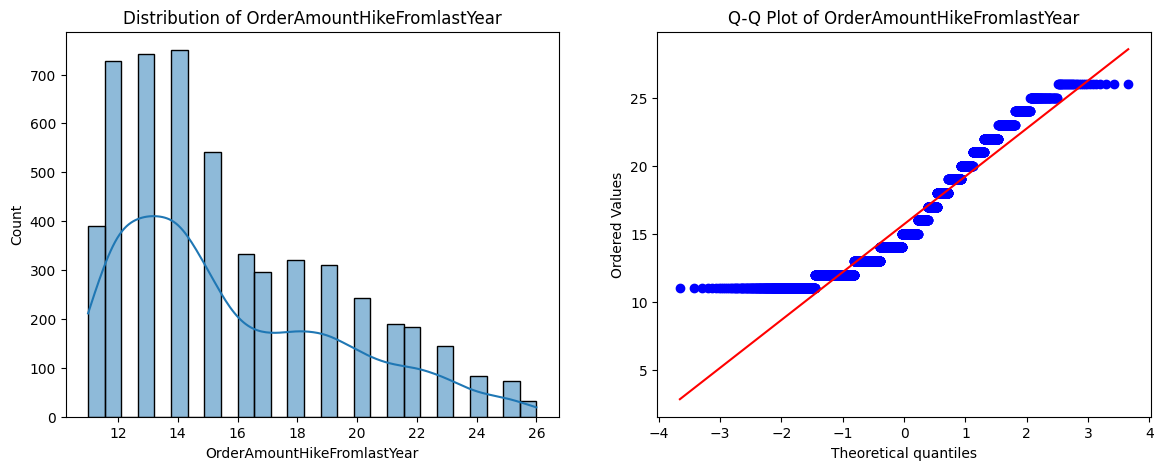

Shapiro-Wilk Test for OrderAmountHikeFromlastYear: Statistics=0.915, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5365.
  res = hypotest_fun_out(*samples, **kwds)


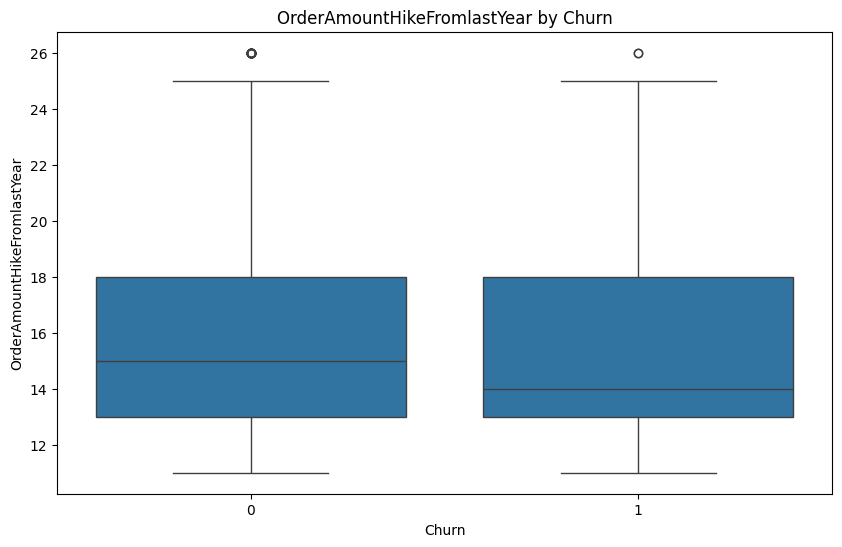

Mann-Whitney U test for OrderAmountHikeFromlastYear: U-statistic=2004453.000, p-value=0.130
Conclusion: There is no significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing Numerical Feature: CouponUsed


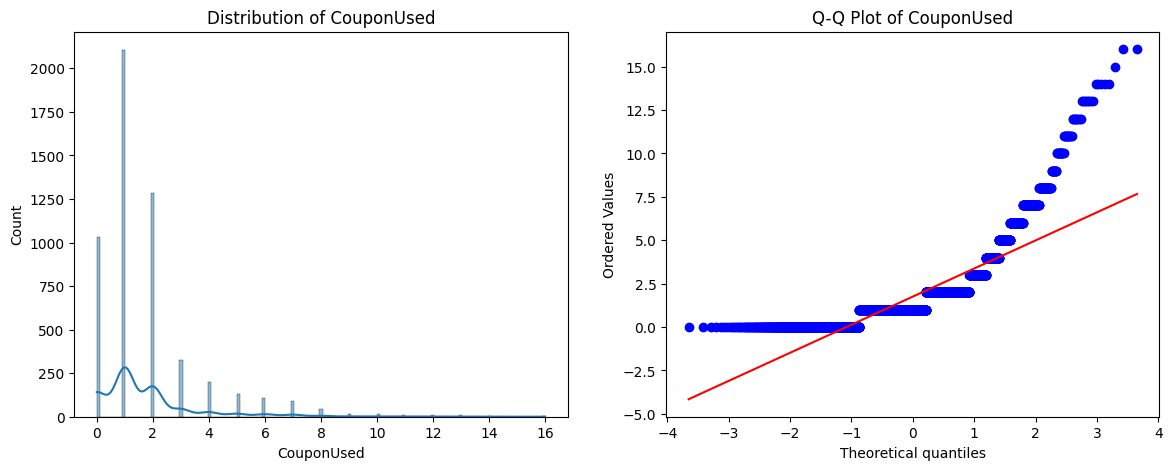

Shapiro-Wilk Test for CouponUsed: Statistics=0.728, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5374.
  res = hypotest_fun_out(*samples, **kwds)


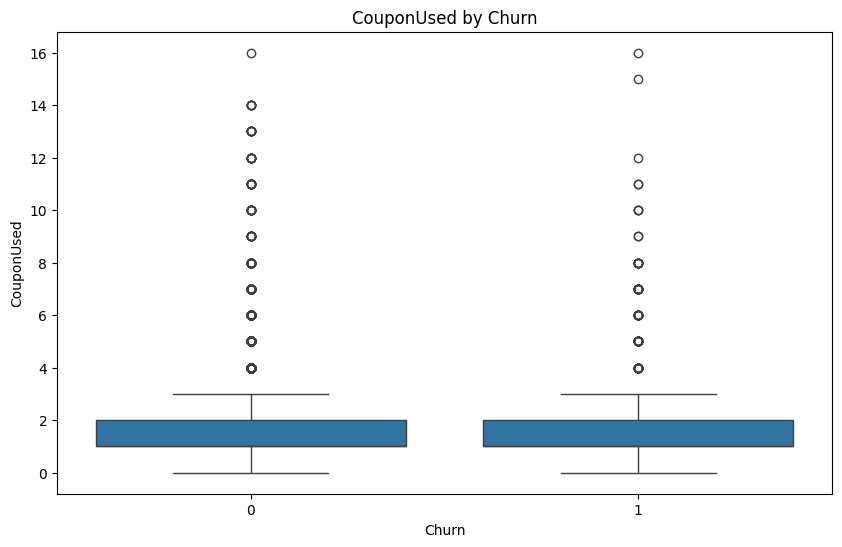

Mann-Whitney U test for CouponUsed: U-statistic=2038042.500, p-value=0.267
Conclusion: There is no significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing Numerical Feature: OrderCount


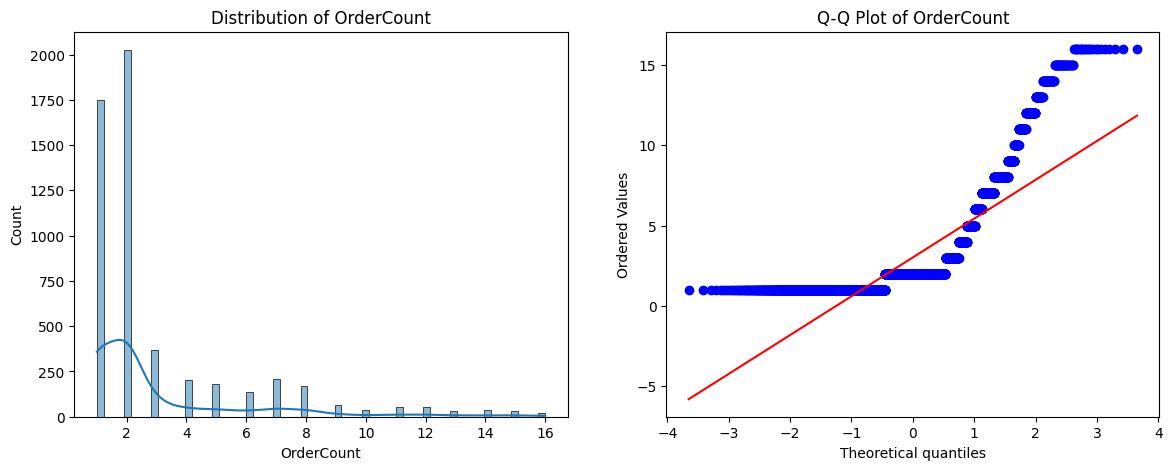

Shapiro-Wilk Test for OrderCount: Statistics=0.677, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5372.
  res = hypotest_fun_out(*samples, **kwds)


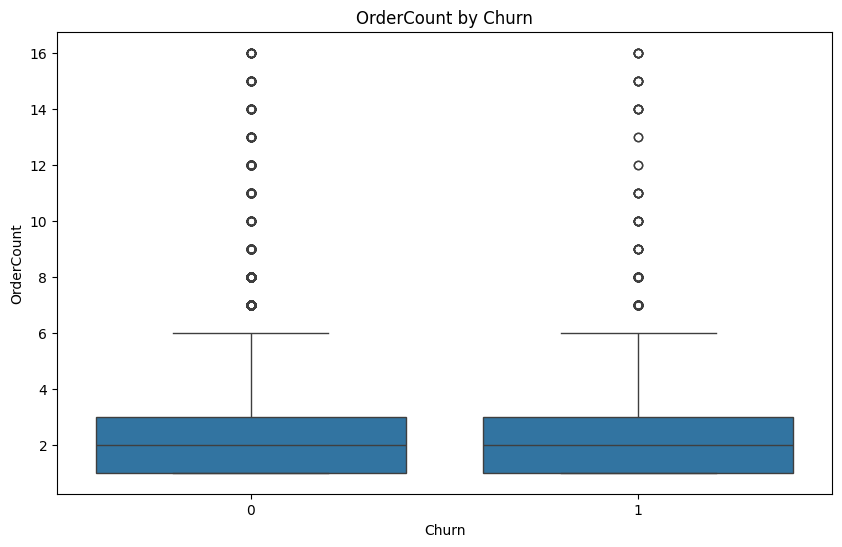

Mann-Whitney U test for OrderCount: U-statistic=1979607.000, p-value=0.036
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing Numerical Feature: DaySinceLastOrder


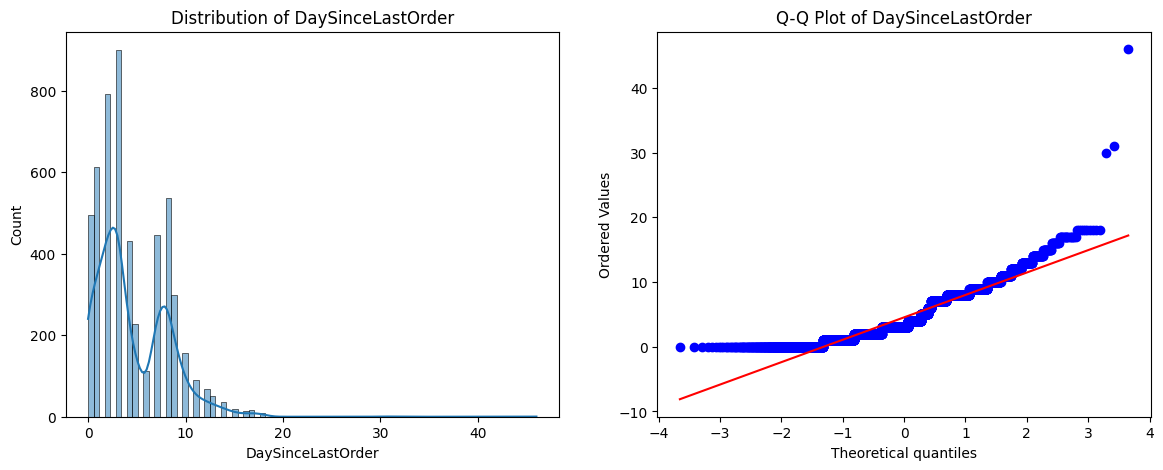

Shapiro-Wilk Test for DaySinceLastOrder: Statistics=0.899, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5323.
  res = hypotest_fun_out(*samples, **kwds)


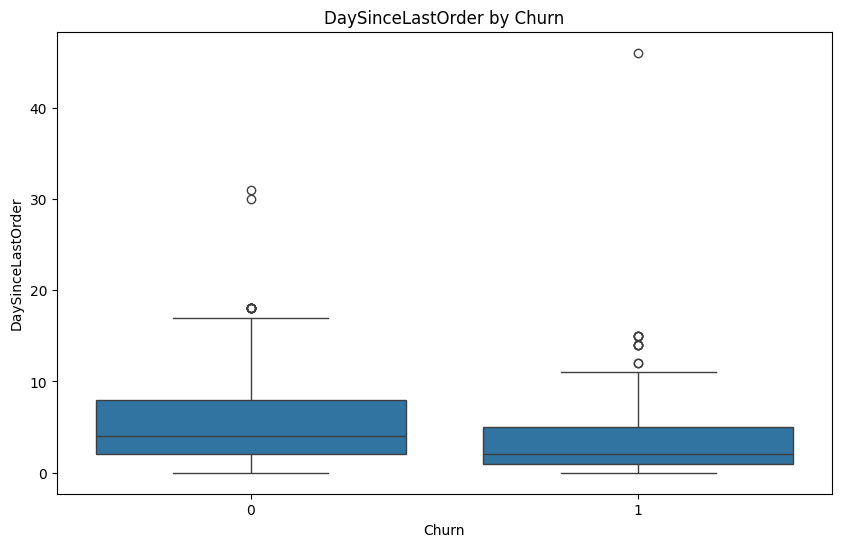

Mann-Whitney U test for DaySinceLastOrder: U-statistic=1412515.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing Numerical Feature: CashbackAmount


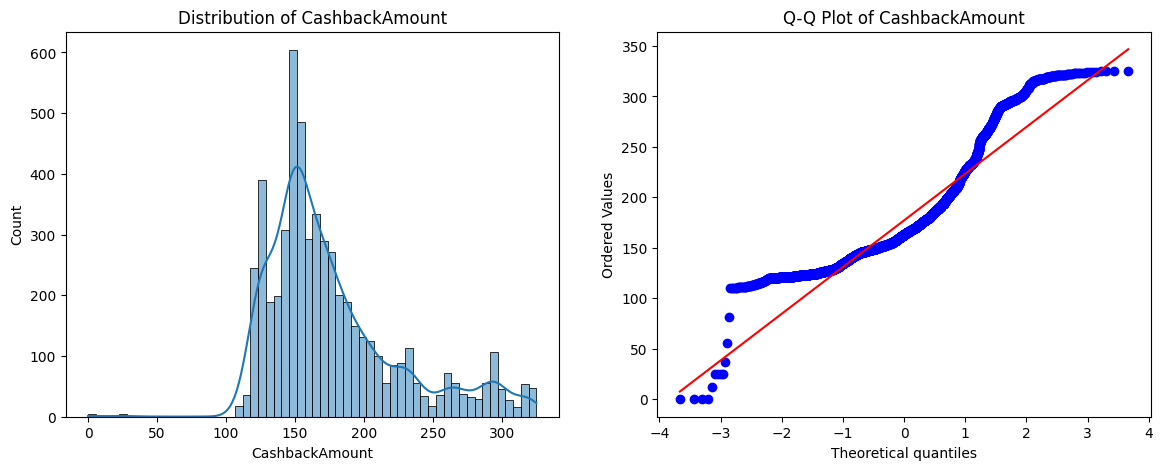

Shapiro-Wilk Test for CashbackAmount: Statistics=0.883, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


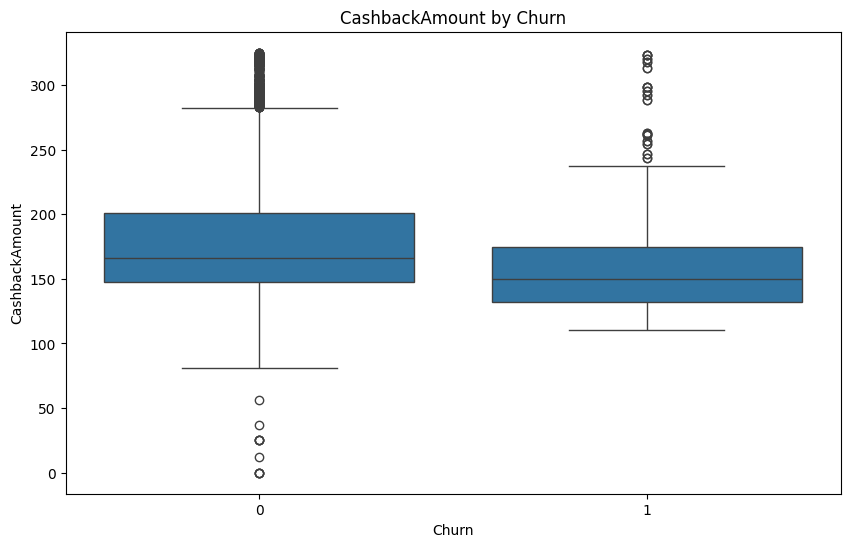

Mann-Whitney U test for CashbackAmount: U-statistic=1628505.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------



In [7]:
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

for col in numerical_features:
    print(f'Analyzing Numerical Feature: {col}')
    # Distribution and Normality Check
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df_ecommerce[col], kde=True)
    plt.title(f'Distribution of {col}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(df_ecommerce[col].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')
    plt.show()
    
    stat, p = stats.shapiro(df_ecommerce[col].dropna())
    print(f'Shapiro-Wilk Test for {col}: Statistics={stat:.3f}, p-value={p:.3f}')
    if p > 0.05:
        print('Conclusion: Sample looks Gaussian (fail to reject H0).')
        normality = True
    else:
        print('Conclusion: Sample does not look Gaussian (reject H0).')
        normality = False
    
    # Distribution by Churn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Churn', y=col, data=df_ecommerce)
    plt.title(f'{col} by Churn')
    plt.show()
    
    churn_yes = df_ecommerce[df_ecommerce['Churn'] == 1][col].dropna()
    churn_no = df_ecommerce[df_ecommerce['Churn'] == 0][col].dropna()
    
    if normality:
        t_stat, t_p = stats.ttest_ind(churn_yes, churn_no)
        print(f'Independent T-test for {col}: T-statistic={t_stat:.3f}, p-value={t_p:.3f}')
        if t_p < 0.05:
            print('Conclusion: There is a significant difference in means between churn groups.')
        else:
            print('Conclusion: There is no significant difference in means between churn groups.')
    else:
        u_stat, u_p = stats.mannwhitneyu(churn_yes, churn_no)
        print(f'Mann-Whitney U test for {col}: U-statistic={u_stat:.3f}, p-value={u_p:.3f}')
        if u_p < 0.05:
            print('Conclusion: There is a significant difference in distributions between churn groups.')
        else:
            print('Conclusion: There is no significant difference in distributions between churn groups.')
    print('\n' + '-'*50 + '\n')

## 6. In-depth Categorical Analysis

### 6.1. Univariate

/tmp/ipykernel_1695060/3389279106.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


--- Starting Univariate Analysis ---

Analyzing Univariate Feature: PreferredLoginDevice


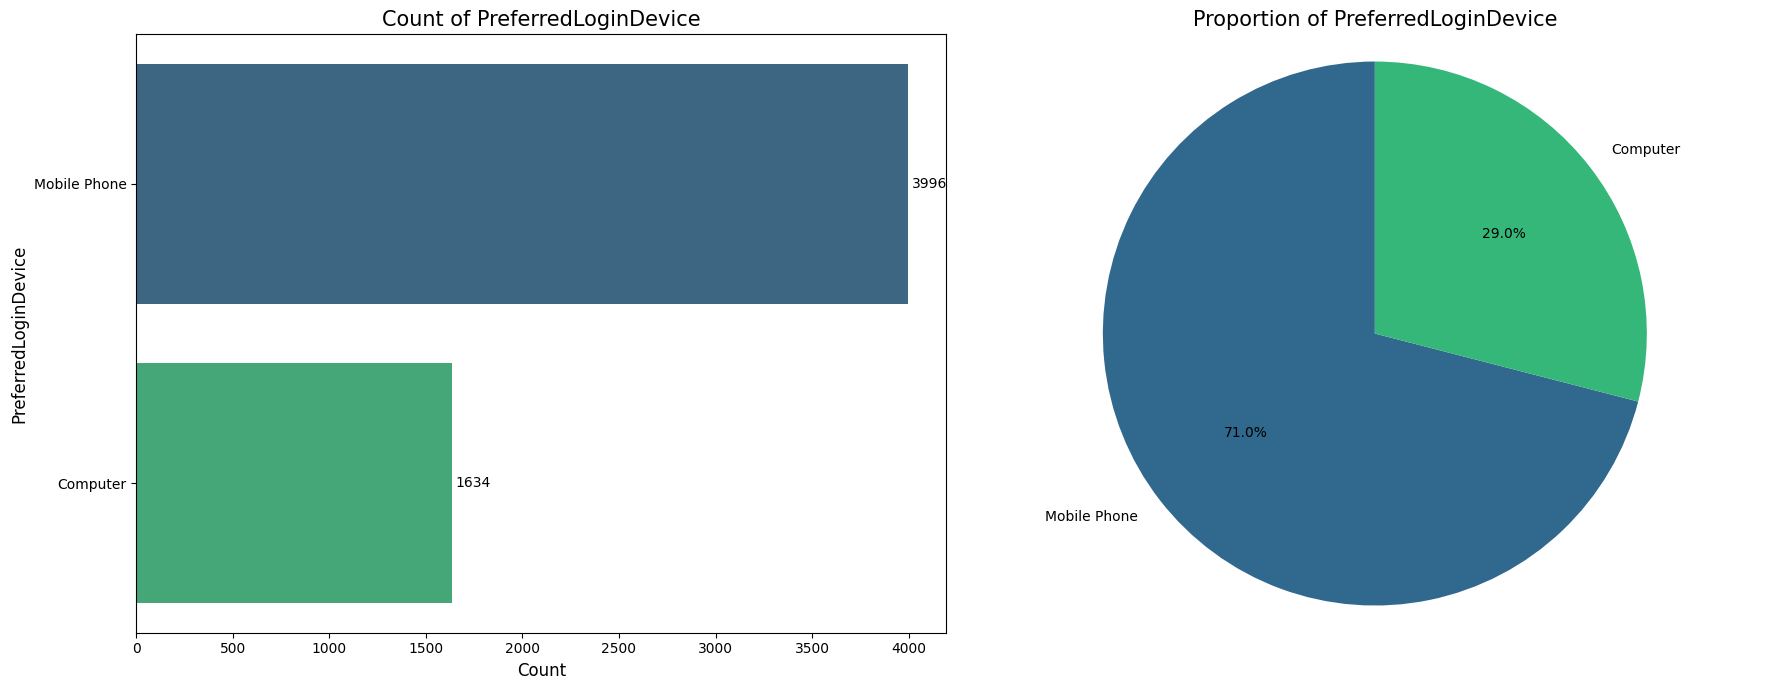

--------------------------------------------------

Analyzing Univariate Feature: PreferredPaymentMode


/tmp/ipykernel_1695060/3389279106.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


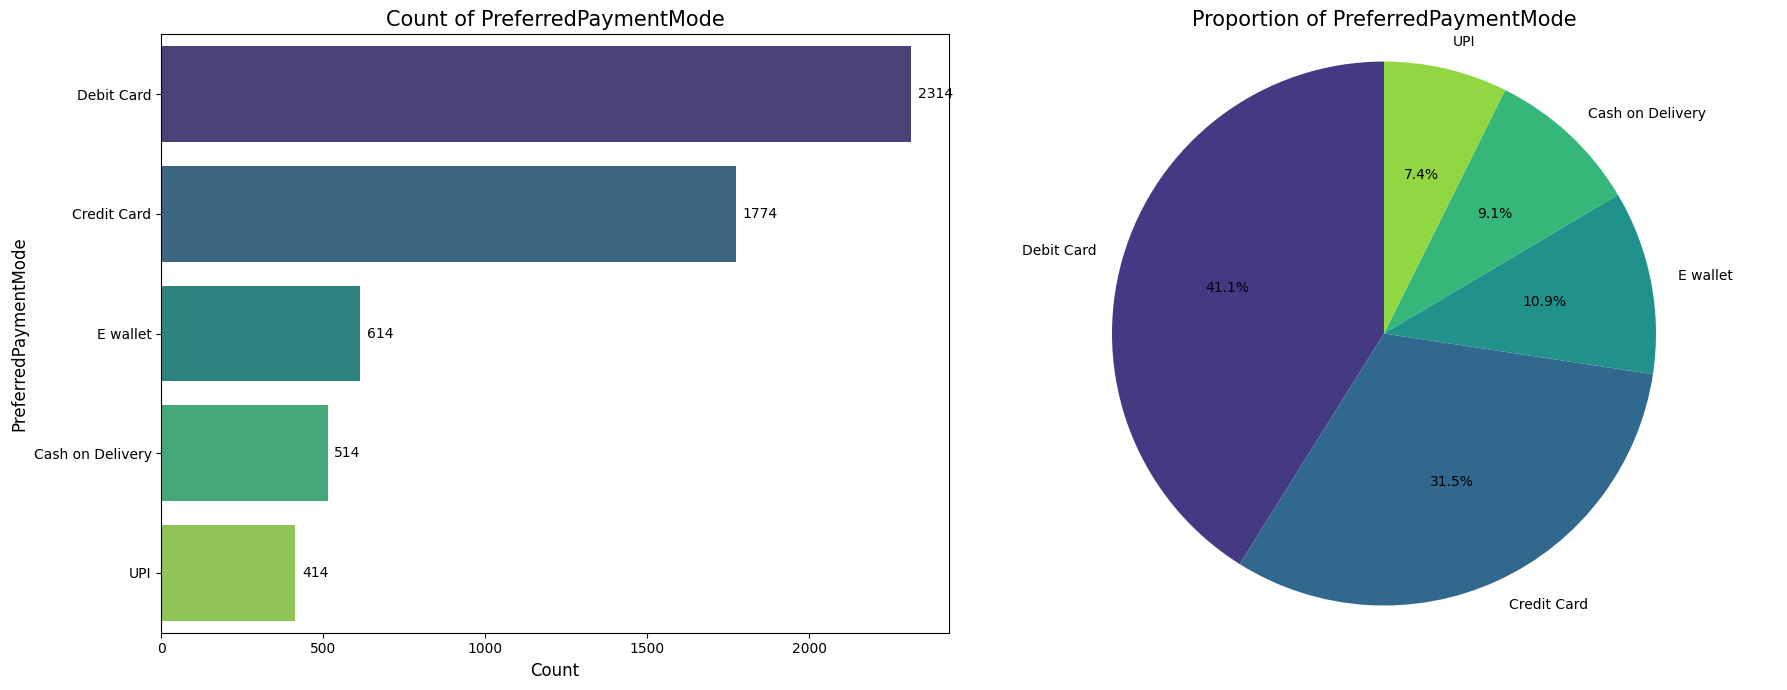

--------------------------------------------------

Analyzing Univariate Feature: Gender


/tmp/ipykernel_1695060/3389279106.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


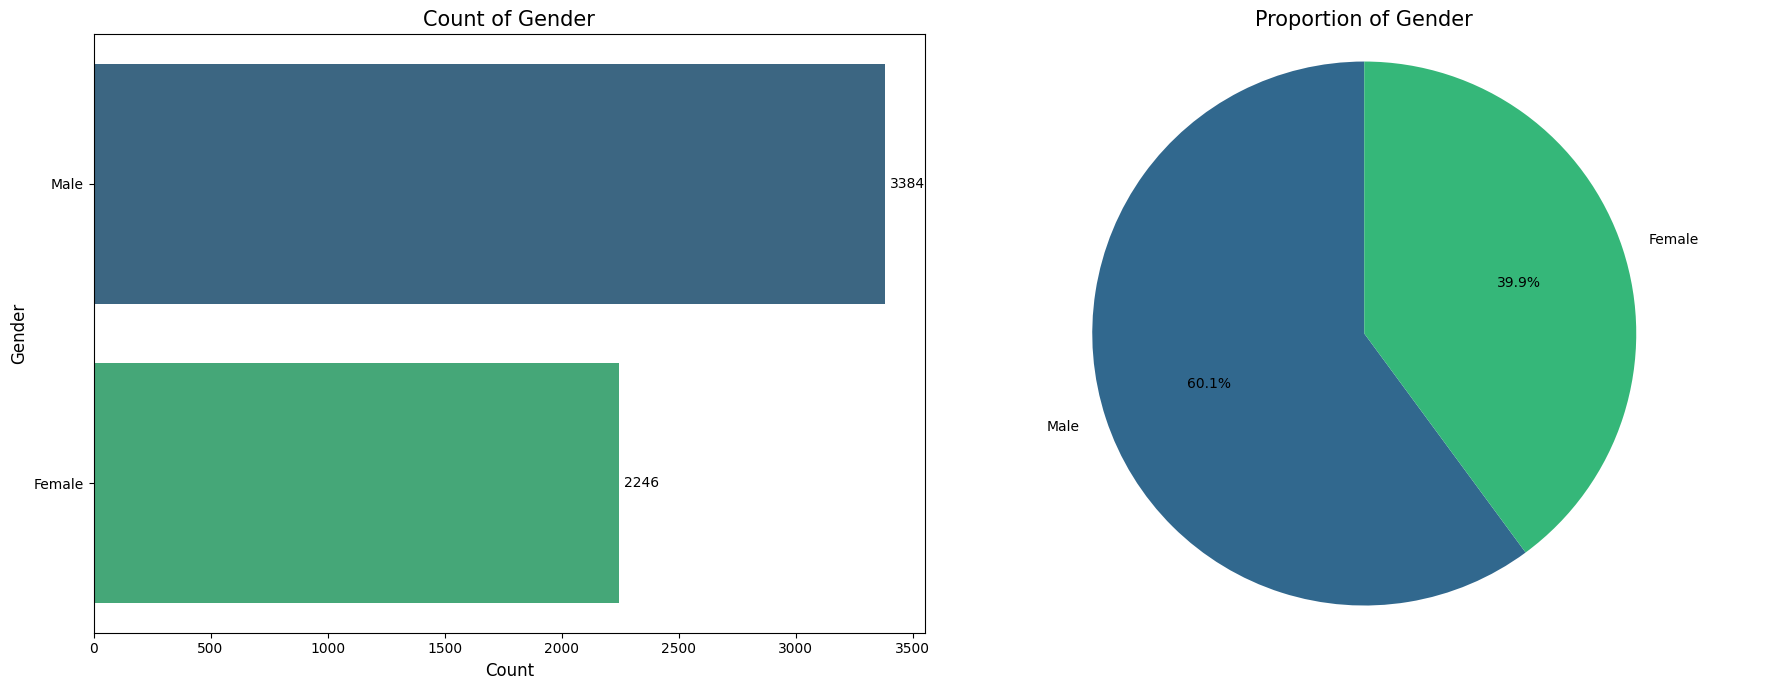

--------------------------------------------------

Analyzing Univariate Feature: PreferedOrderCat


/tmp/ipykernel_1695060/3389279106.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


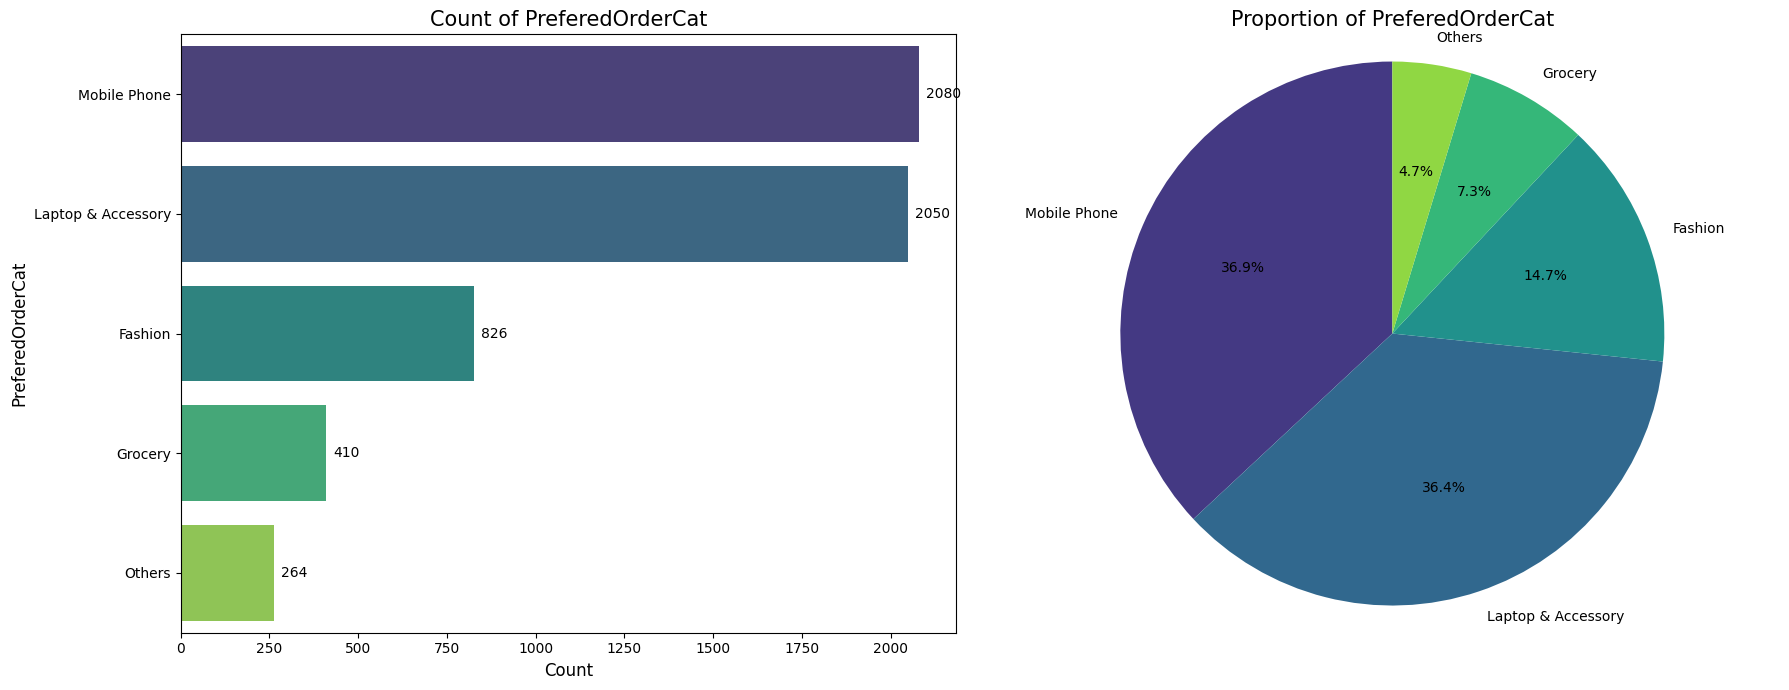

--------------------------------------------------

Analyzing Univariate Feature: MaritalStatus


/tmp/ipykernel_1695060/3389279106.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


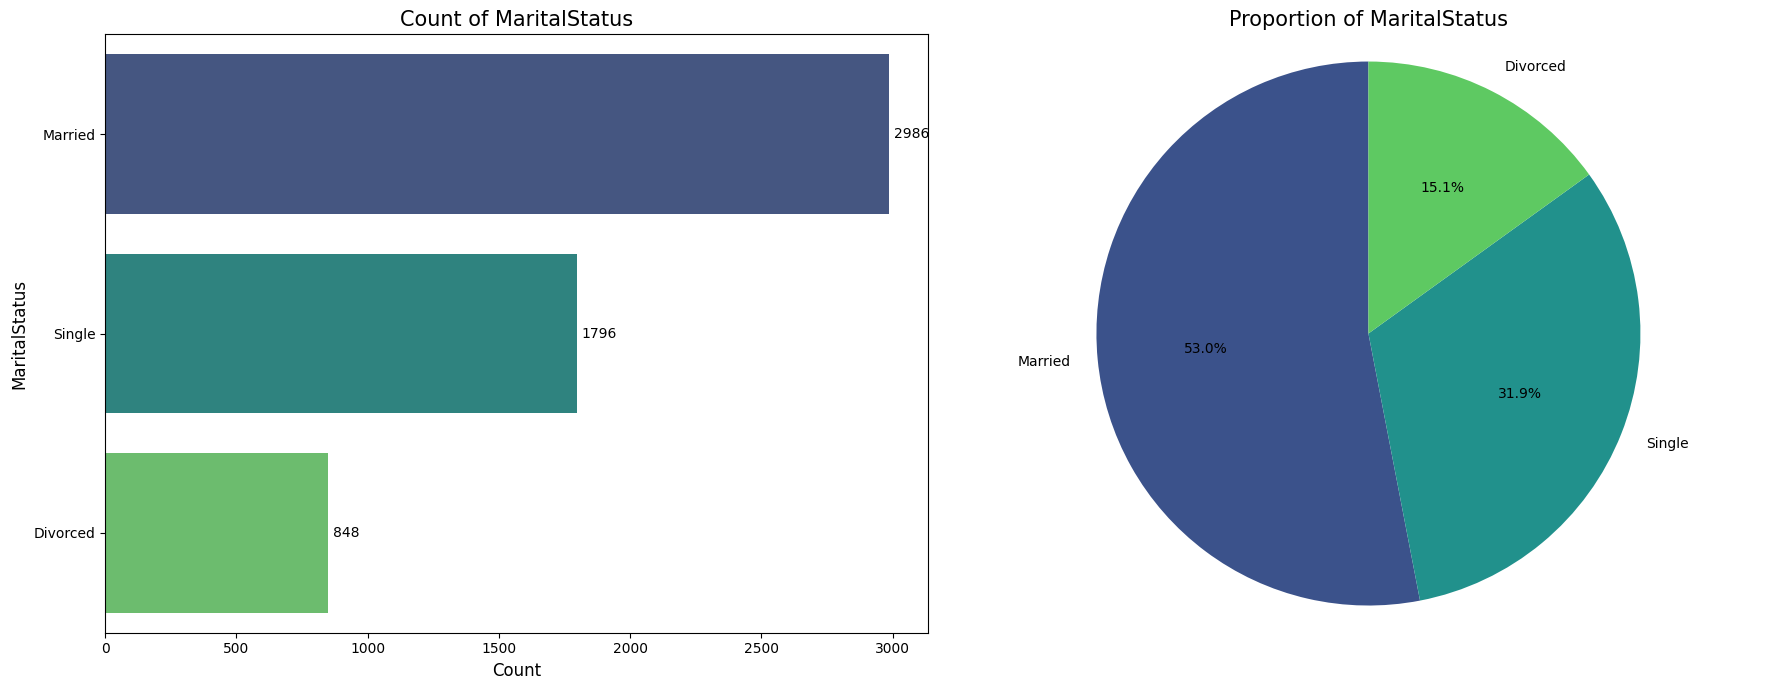

--------------------------------------------------

Analyzing Univariate Feature: CityTier


/tmp/ipykernel_1695060/3389279106.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


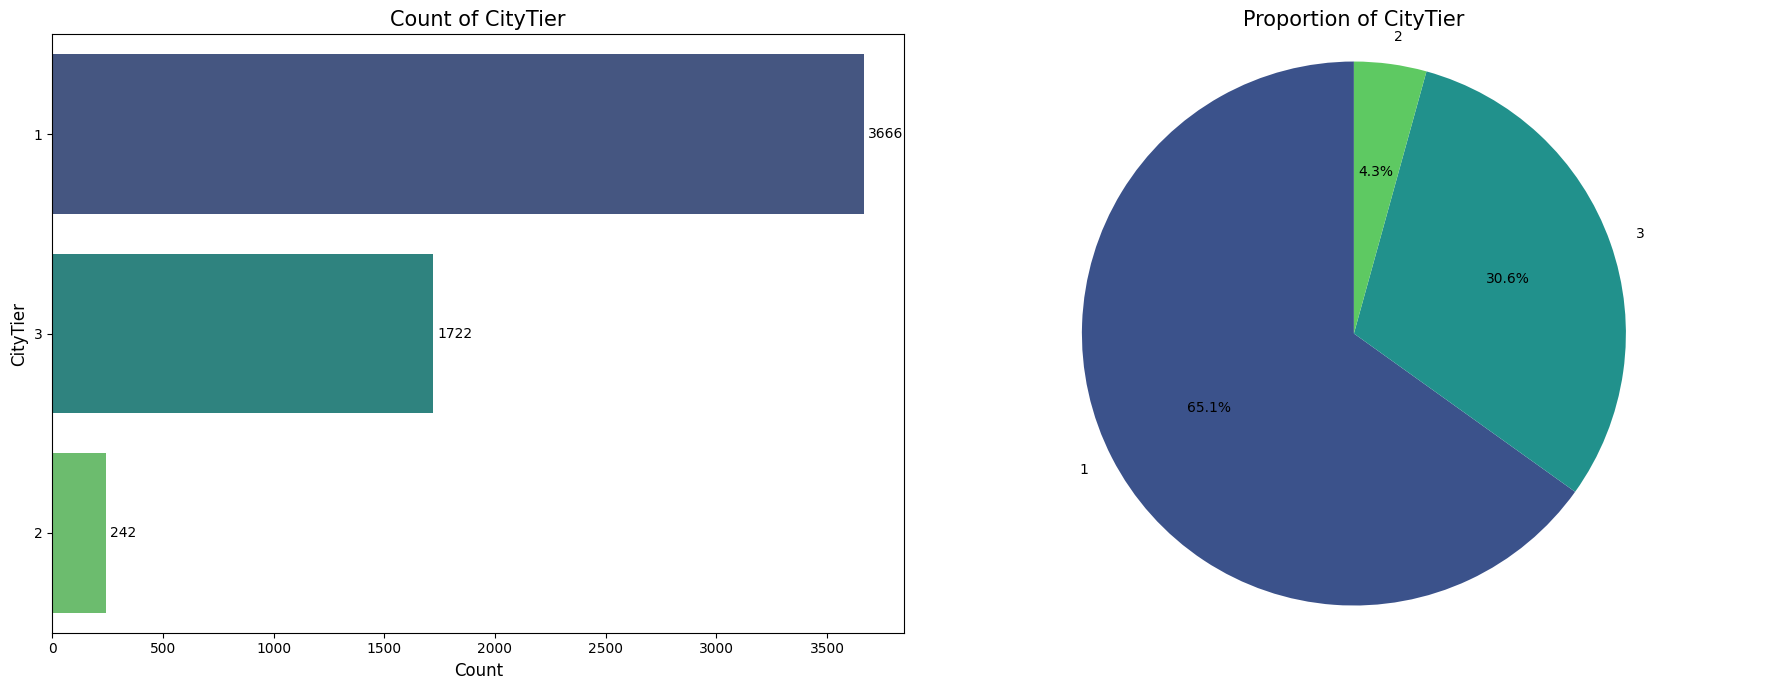

--------------------------------------------------

Analyzing Univariate Feature: SatisfactionScore


/tmp/ipykernel_1695060/3389279106.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


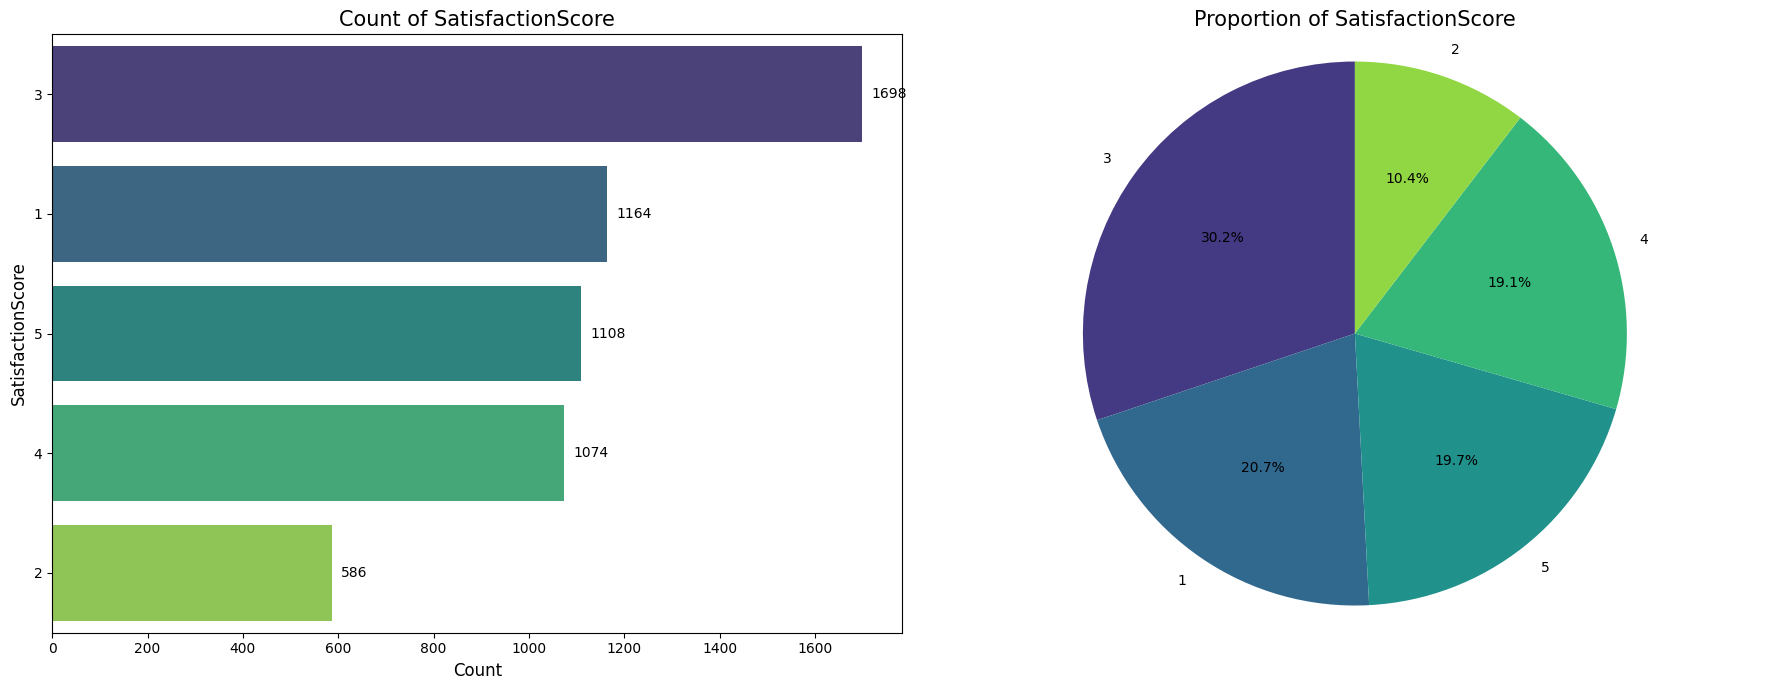

--------------------------------------------------

Analyzing Univariate Feature: Complain


/tmp/ipykernel_1695060/3389279106.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


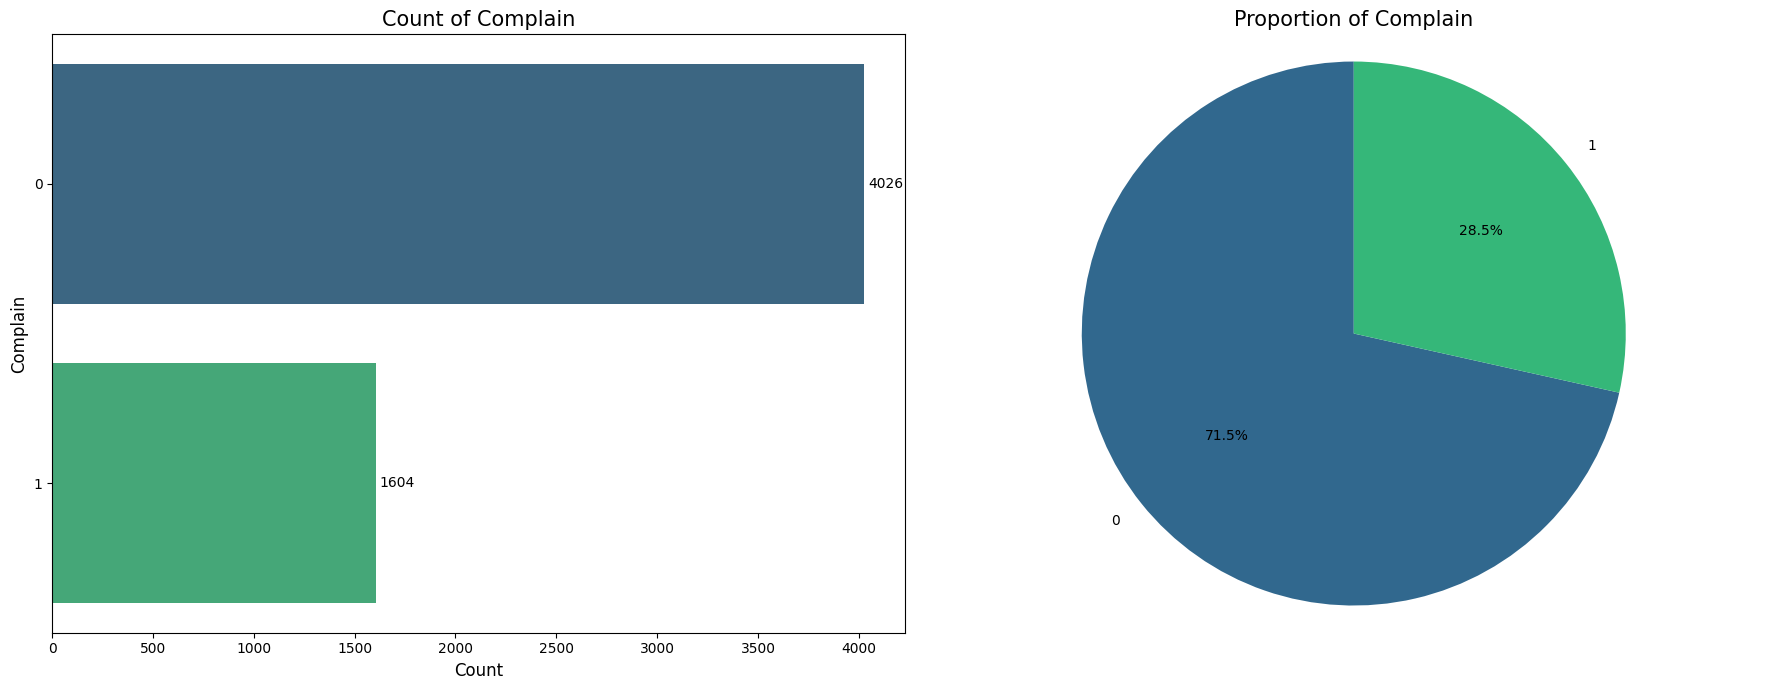

--------------------------------------------------


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_ecommerce is already loaded
# Example: df_ecommerce = pd.read_csv('your_data_file.csv')

# Define all categorical features to analyze
categorical_features = df_ecommerce.select_dtypes(include='object').columns.tolist()
ordinal_binary_features = ['CityTier', 'SatisfactionScore', 'Complain']
all_categorical = categorical_features + ordinal_binary_features

print("--- Starting Univariate Analysis ---")

for col in all_categorical:
    print(f'\nAnalyzing Univariate Feature: {col}')
    
    # Check for "super minority" classes (e.g., less than 1% of the total)
    total_count = len(df_ecommerce[col])
    value_counts = df_ecommerce[col].value_counts(normalize=True)
    minority_classes = value_counts[value_counts < 0.01].index.tolist()
    
    if minority_classes:
        print(f"Warning: The following classes in '{col}' are super minority classes (<1%): {minority_classes}")
        print("Consider grouping these classes for better analysis/modeling.")

    plt.figure(figsize=(18, 7))

    # Subplot 1: Countplot for absolute counts
    plt.subplot(1, 2, 1)
    ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')
    plt.title(f'Count of {col}', fontsize=15)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col, fontsize=12)
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 20, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')

    # Subplot 2: Pie chart for proportions
    plt.subplot(1, 2, 2)
    counts = df_ecommerce[col].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(counts)))
    plt.title(f'Proportion of {col}', fontsize=15)
    plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.tight_layout()
    plt.show()
    
    print("-" * 50)

### 6.2. Bivariate

--- Starting Bivariate Analysis with Churn ---

Analyzing Bivariate Feature: PreferredLoginDevice vs. Churn


<Figure size 1200x700 with 0 Axes>

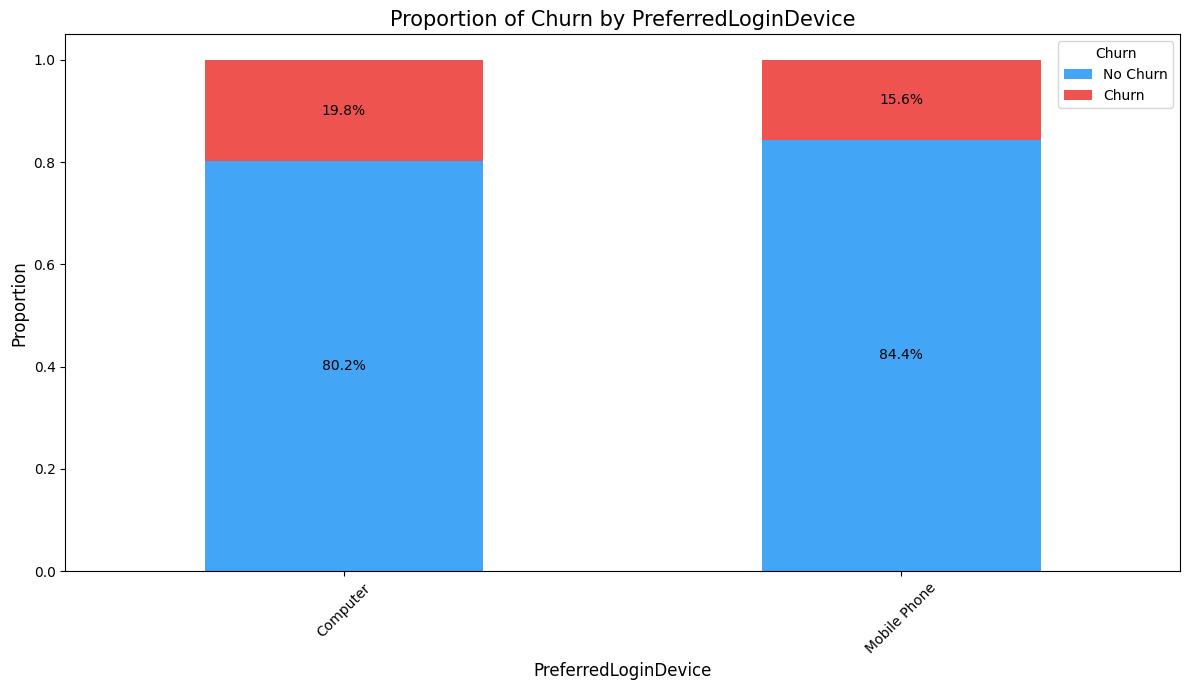

Chi-squared Test for PreferredLoginDevice: Chi2-statistic=14.401, p-value=0.000
Conclusion: There is a statistically significant association between PreferredLoginDevice and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: PreferredPaymentMode vs. Churn


<Figure size 1200x700 with 0 Axes>

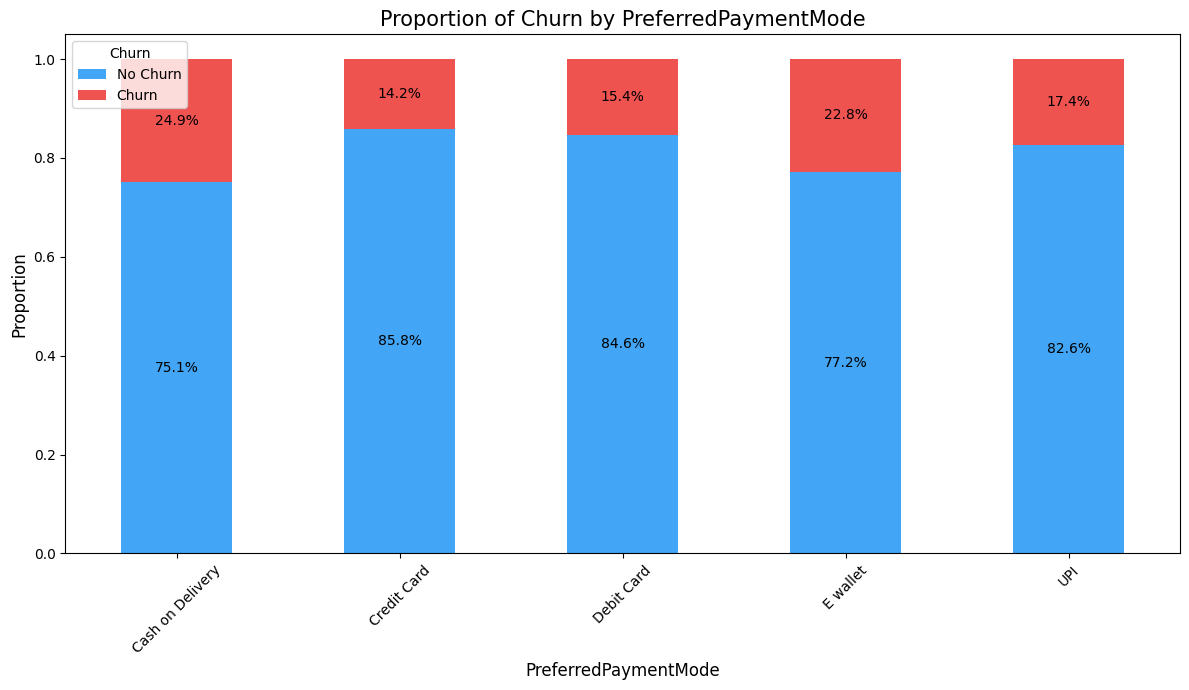

Chi-squared Test for PreferredPaymentMode: Chi2-statistic=51.829, p-value=0.000
Conclusion: There is a statistically significant association between PreferredPaymentMode and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: Gender vs. Churn


<Figure size 1200x700 with 0 Axes>

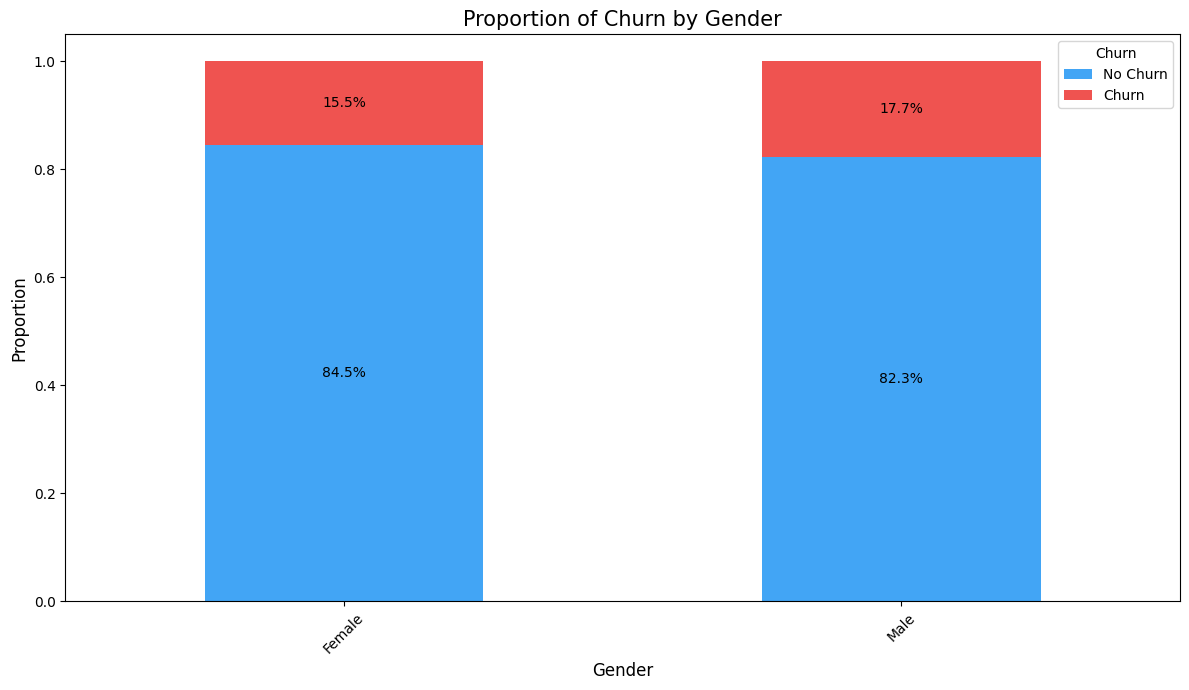

Chi-squared Test for Gender: Chi2-statistic=4.663, p-value=0.031
Conclusion: There is a statistically significant association between Gender and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: PreferedOrderCat vs. Churn


<Figure size 1200x700 with 0 Axes>

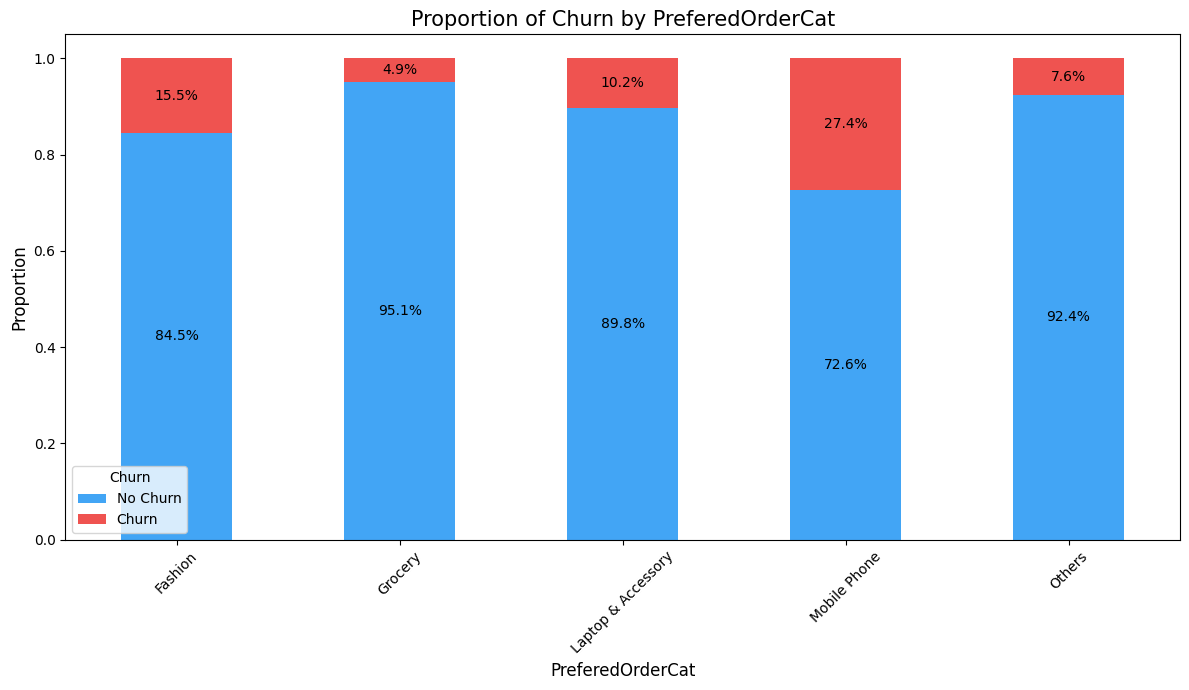

Chi-squared Test for PreferedOrderCat: Chi2-statistic=288.598, p-value=0.000
Conclusion: There is a statistically significant association between PreferedOrderCat and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: MaritalStatus vs. Churn


<Figure size 1200x700 with 0 Axes>

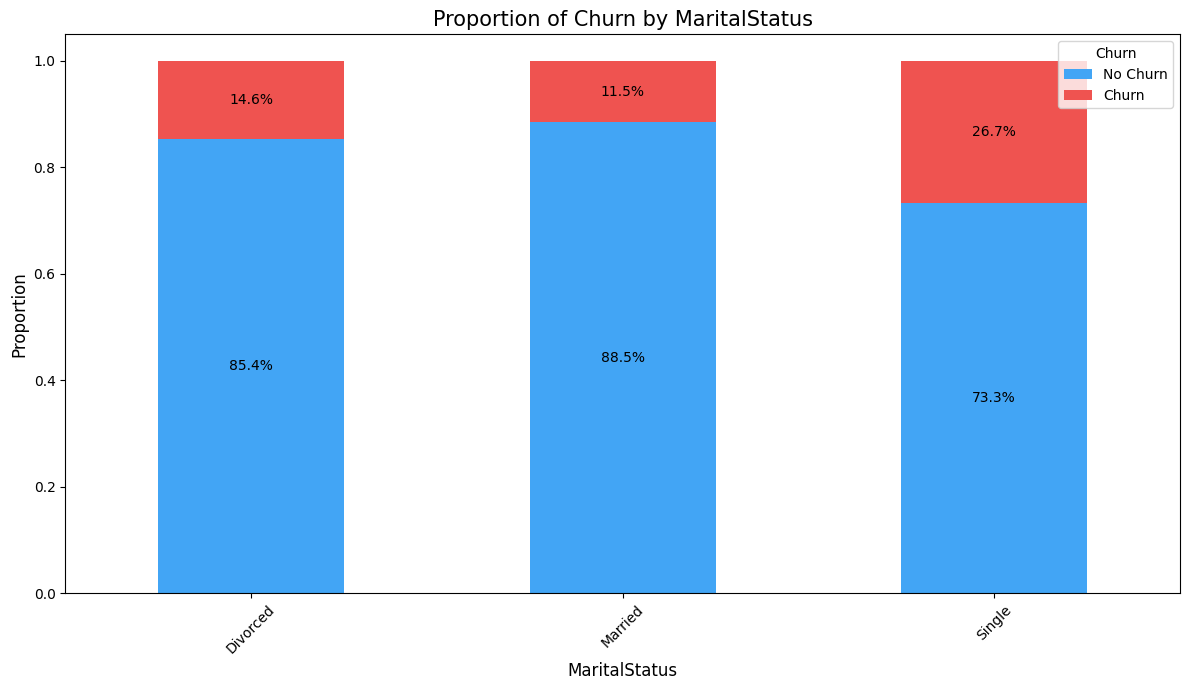

Chi-squared Test for MaritalStatus: Chi2-statistic=188.671, p-value=0.000
Conclusion: There is a statistically significant association between MaritalStatus and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: CityTier vs. Churn


<Figure size 1200x700 with 0 Axes>

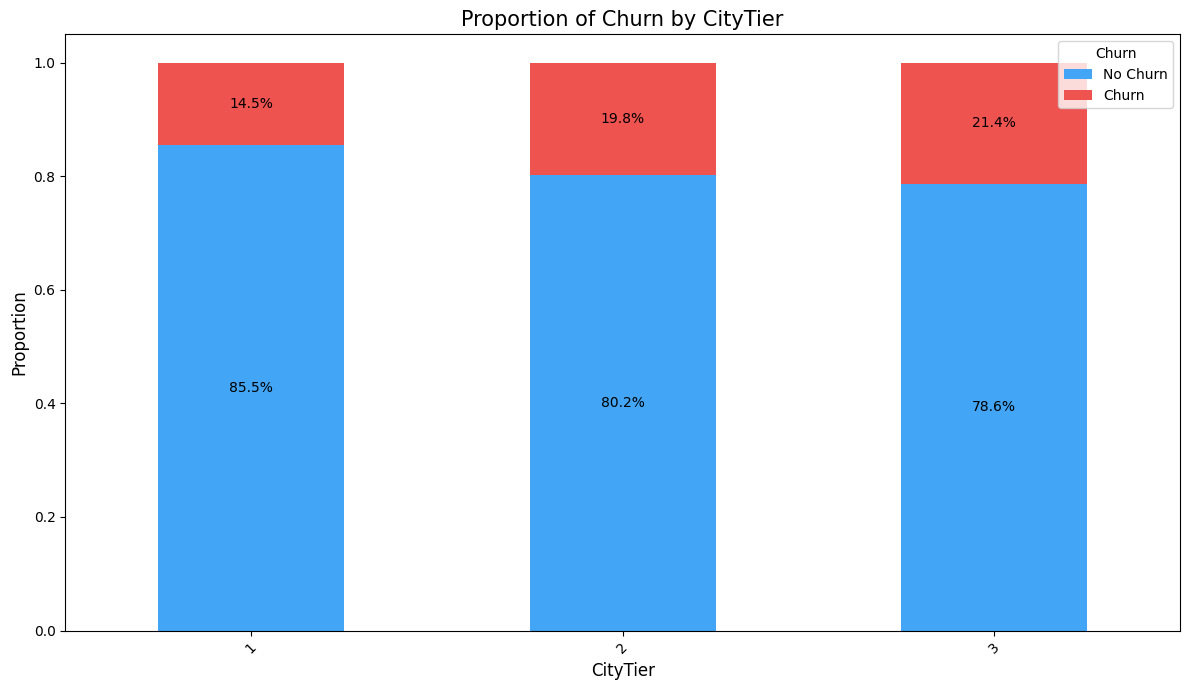

Chi-squared Test for CityTier: Chi2-statistic=40.982, p-value=0.000
Conclusion: There is a statistically significant association between CityTier and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: SatisfactionScore vs. Churn


<Figure size 1200x700 with 0 Axes>

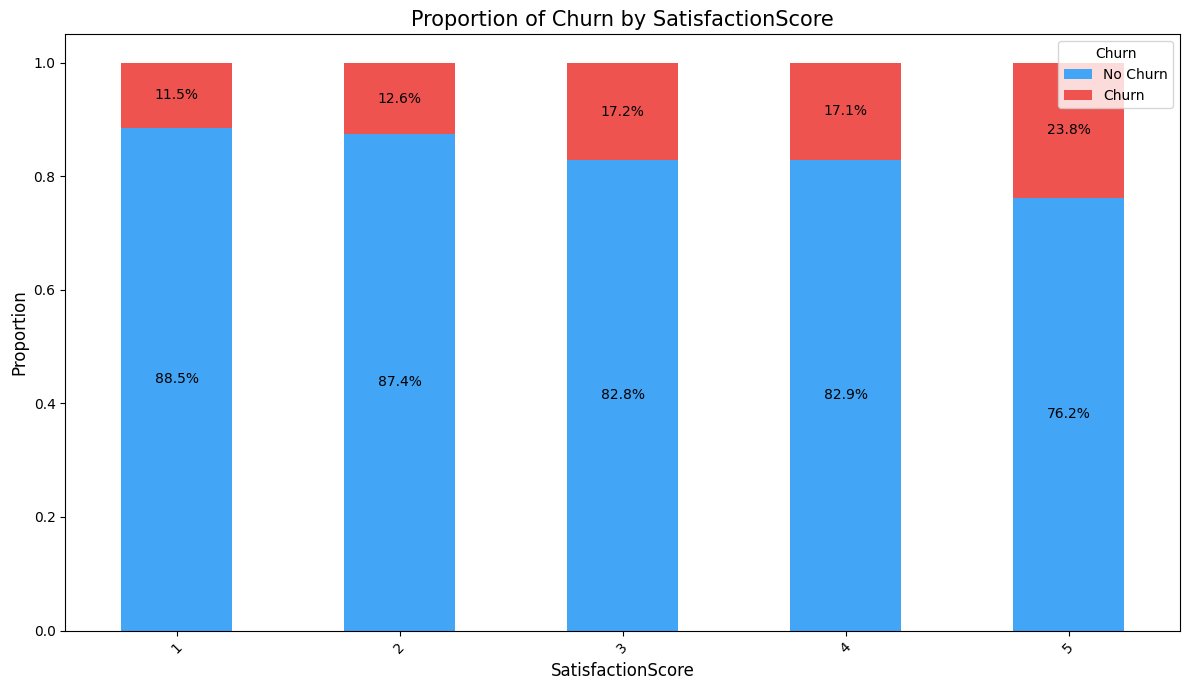

Chi-squared Test for SatisfactionScore: Chi2-statistic=69.865, p-value=0.000
Conclusion: There is a statistically significant association between SatisfactionScore and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: Complain vs. Churn


<Figure size 1200x700 with 0 Axes>

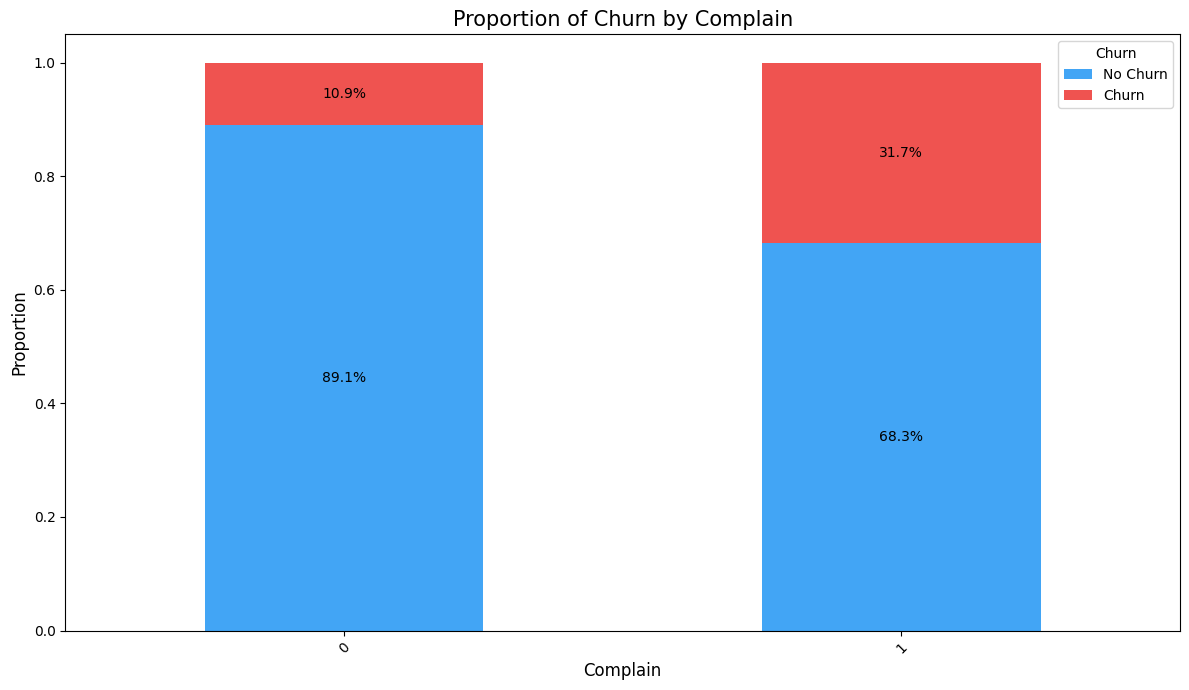

Chi-squared Test for Complain: Chi2-statistic=350.925, p-value=0.000
Conclusion: There is a statistically significant association between Complain and Churn.
--------------------------------------------------


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming df_ecommerce is already loaded and all_categorical is defined from Cell 1

print("--- Starting Bivariate Analysis with Churn ---")

for col in all_categorical:
    print(f'\nAnalyzing Bivariate Feature: {col} vs. Churn')

    # Calculate churn proportion for each category
    churn_proportion = df_ecommerce.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)
    
    # The '.unstack()' operation might re-order columns; ensure 'Churn' and 'No Churn' are in the right order
    churn_proportion = churn_proportion.sort_index(axis=1)

    # Visualization: Bar plot with proportion numbers
    plt.figure(figsize=(12, 7))
    ax = churn_proportion.plot(kind='bar', stacked=True, figsize=(12, 7), color=['#42a5f5', '#ef5350'])
    
    plt.title(f'Proportion of Churn by {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Churn', labels=['No Churn', 'Churn'])

    # Add proportion labels to the bars
    for c in ax.containers:
        labels = [f'{v.get_height():.1%}' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

    # Chi-squared Test for Association
    contingency_table = pd.crosstab(df_ecommerce[col], df_ecommerce['Churn'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f'Chi-squared Test for {col}: Chi2-statistic={chi2:.3f}, p-value={p:.3f}')
    
    if p < 0.05:
        print(f'Conclusion: There is a statistically significant association between {col} and Churn.')
    else:
        print(f'Conclusion: There is no statistically significant association between {col} and Churn.')
        
    print("-" * 50)

--- Starting Bivariate Analysis with Churn ---

Analyzing Bivariate Feature: PreferredLoginDevice vs. Churn


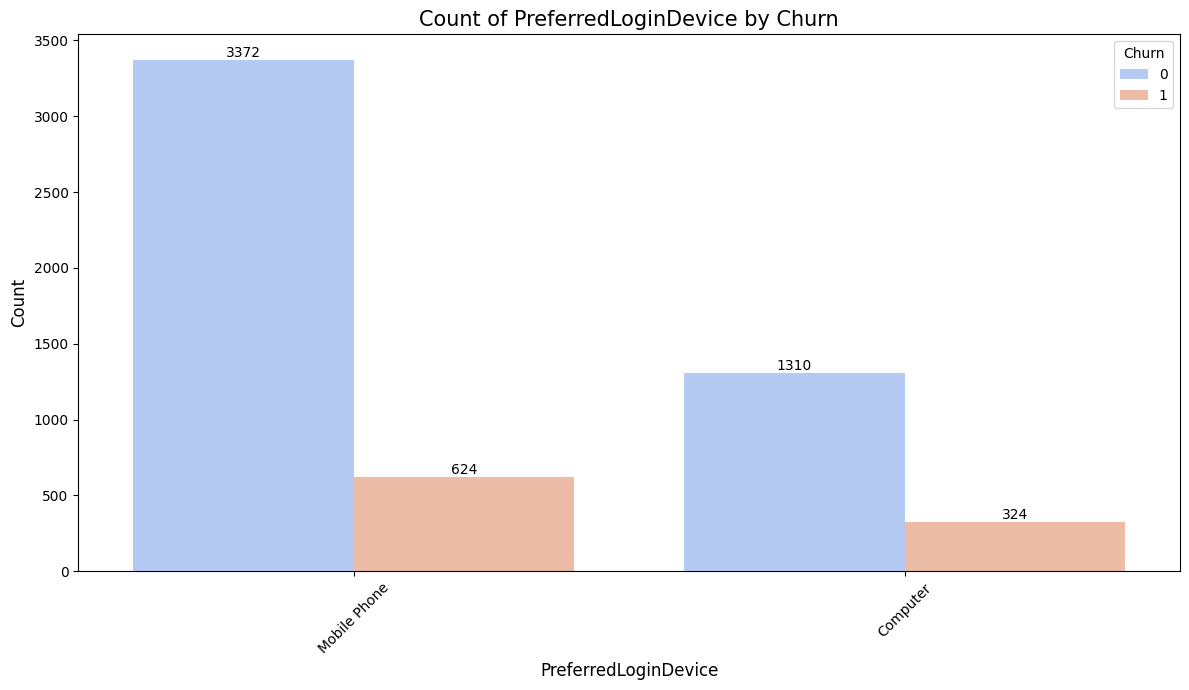

Chi-squared Test for PreferredLoginDevice: Chi2-statistic=14.401, p-value=0.000
Conclusion: There is a statistically significant association between PreferredLoginDevice and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: PreferredPaymentMode vs. Churn


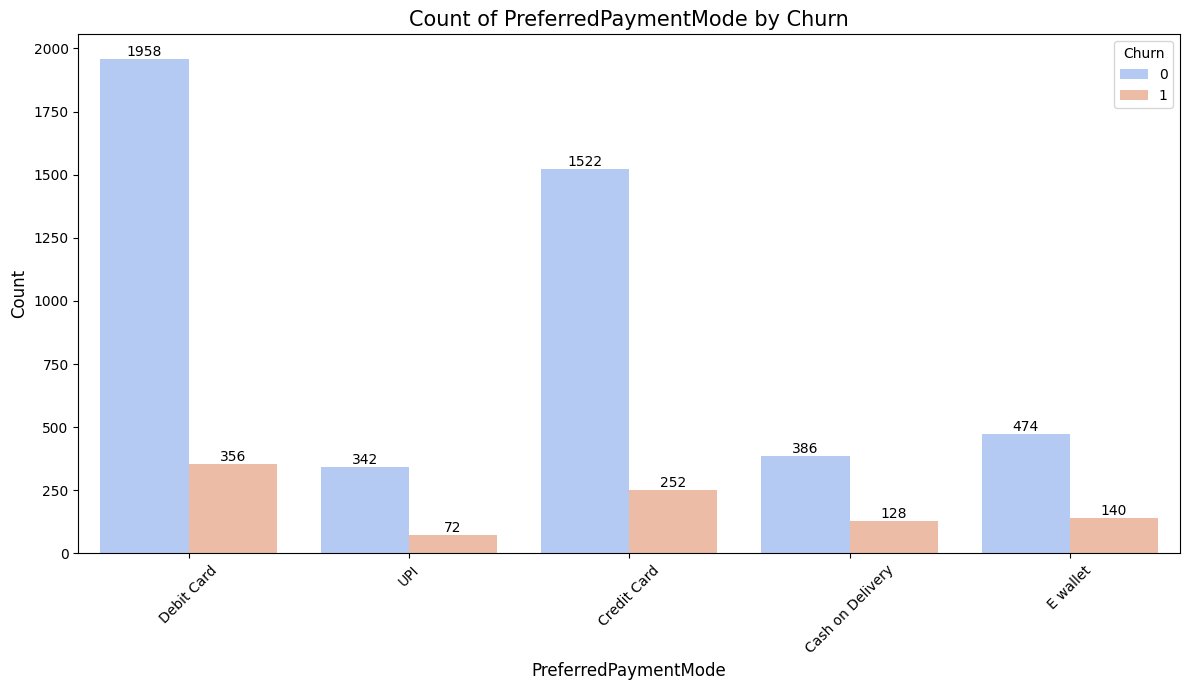

Chi-squared Test for PreferredPaymentMode: Chi2-statistic=51.829, p-value=0.000
Conclusion: There is a statistically significant association between PreferredPaymentMode and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: Gender vs. Churn


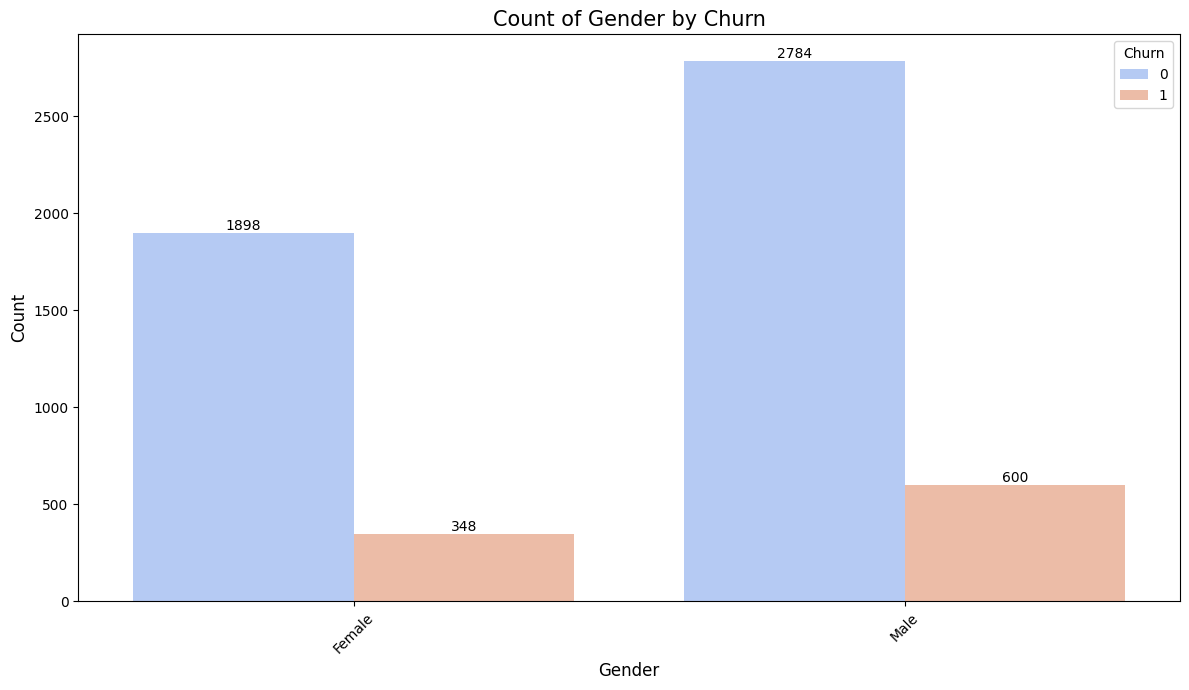

Chi-squared Test for Gender: Chi2-statistic=4.663, p-value=0.031
Conclusion: There is a statistically significant association between Gender and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: PreferedOrderCat vs. Churn


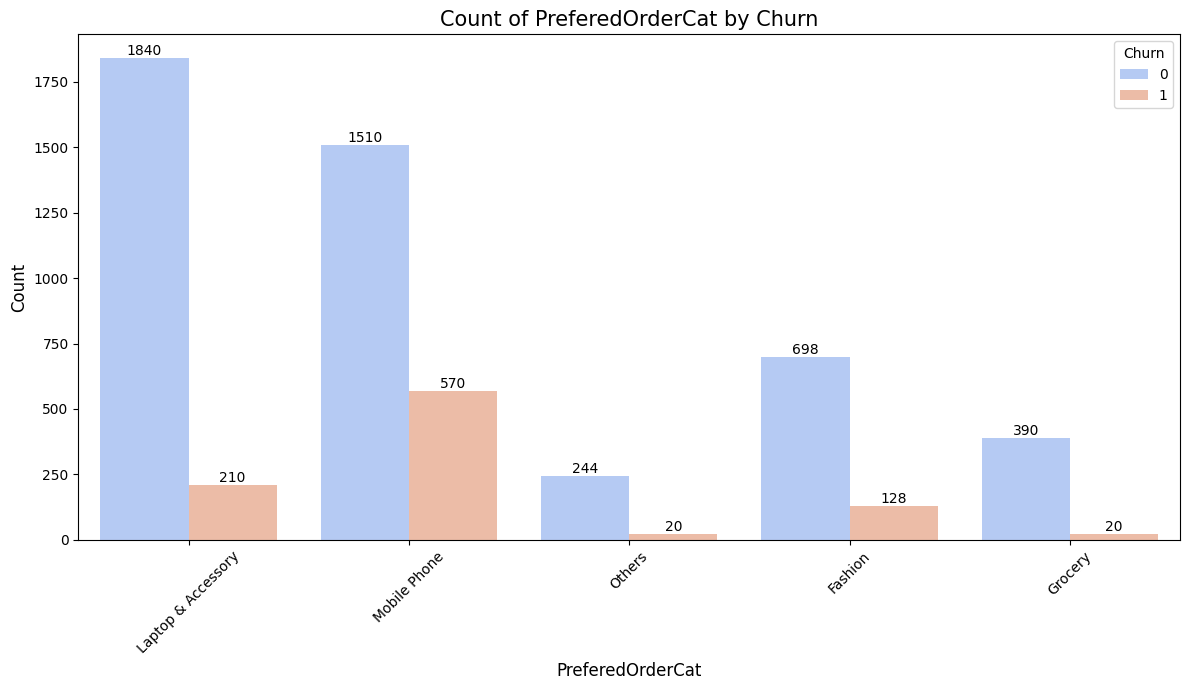

Chi-squared Test for PreferedOrderCat: Chi2-statistic=288.598, p-value=0.000
Conclusion: There is a statistically significant association between PreferedOrderCat and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: MaritalStatus vs. Churn


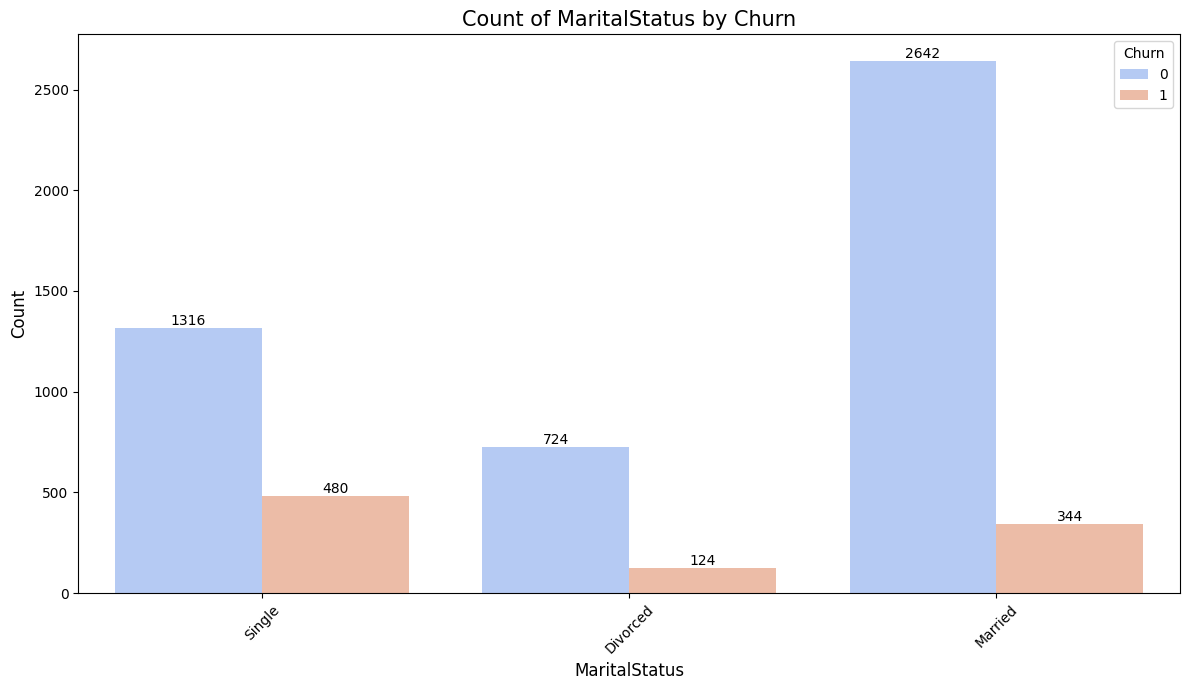

Chi-squared Test for MaritalStatus: Chi2-statistic=188.671, p-value=0.000
Conclusion: There is a statistically significant association between MaritalStatus and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: CityTier vs. Churn


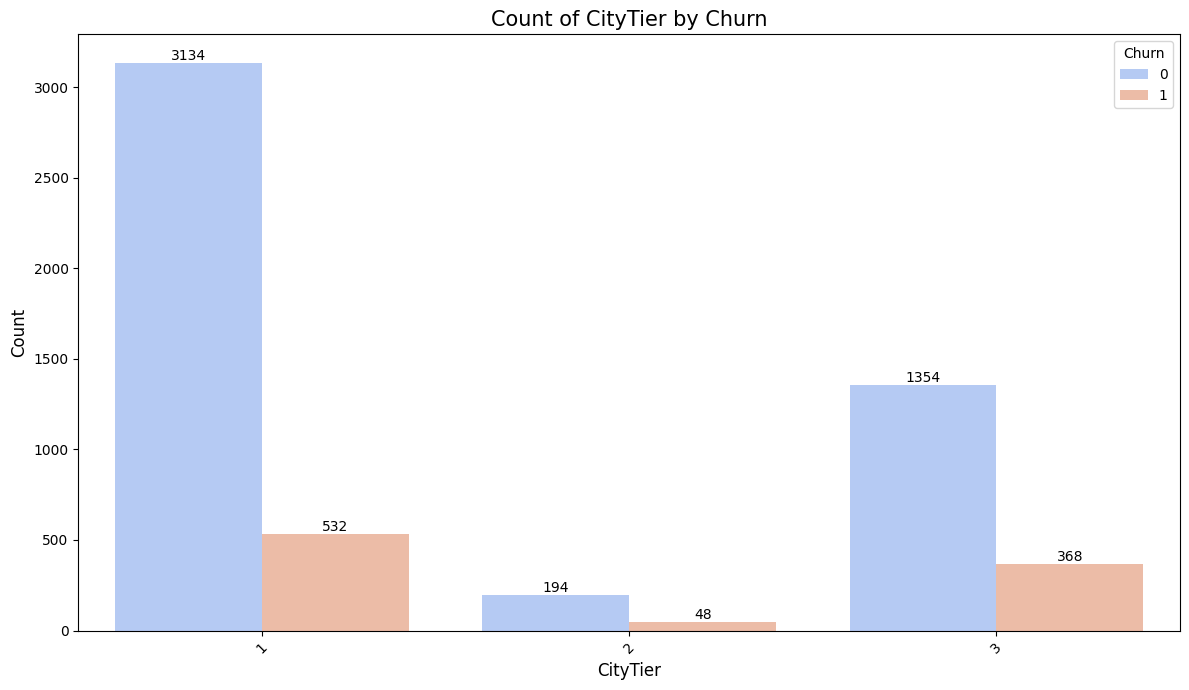

Chi-squared Test for CityTier: Chi2-statistic=40.982, p-value=0.000
Conclusion: There is a statistically significant association between CityTier and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: SatisfactionScore vs. Churn


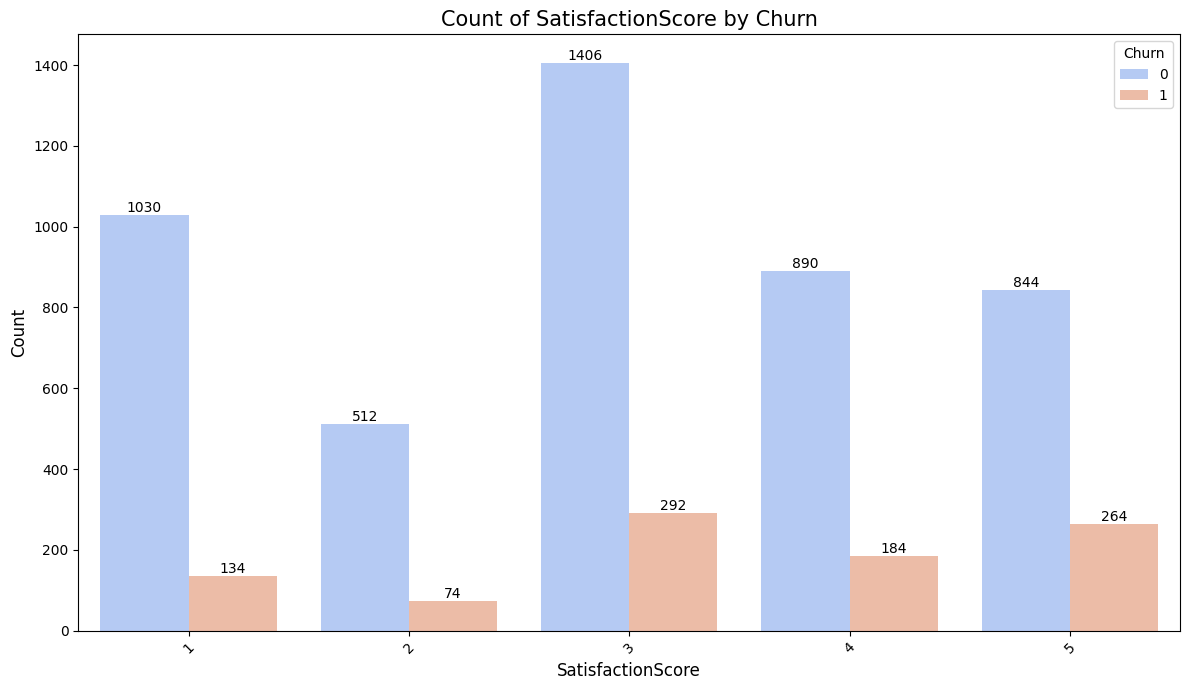

Chi-squared Test for SatisfactionScore: Chi2-statistic=69.865, p-value=0.000
Conclusion: There is a statistically significant association between SatisfactionScore and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: Complain vs. Churn


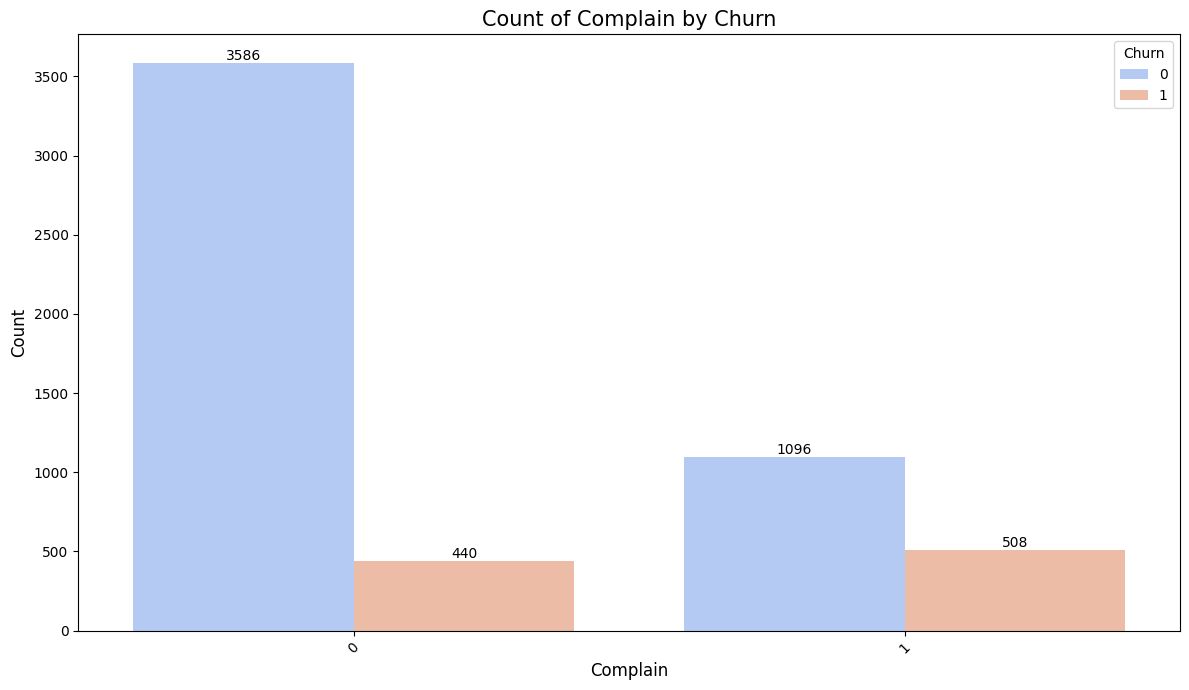

Chi-squared Test for Complain: Chi2-statistic=350.925, p-value=0.000
Conclusion: There is a statistically significant association between Complain and Churn.
--------------------------------------------------


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming df_ecommerce is already loaded and all_categorical is defined

print("--- Starting Bivariate Analysis with Churn ---")

for col in all_categorical:
    print(f'\nAnalyzing Bivariate Feature: {col} vs. Churn')

    # Visualization: Grouped Countplot for counts
    plt.figure(figsize=(12, 7))
    ax = sns.countplot(data=df_ecommerce, x=col, hue='Churn', palette='coolwarm')
    plt.title(f'Count of {col} by Churn', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)

    # Add count labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontsize=10)
    
    plt.tight_layout()
    plt.show()

    # Chi-squared Test for Association
    contingency_table = pd.crosstab(df_ecommerce[col], df_ecommerce['Churn'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f'Chi-squared Test for {col}: Chi2-statistic={chi2:.3f}, p-value={p:.3f}')
    
    if p < 0.05:
        print(f'Conclusion: There is a statistically significant association between {col} and Churn.')
    else:
        print(f'Conclusion: There is no statistically significant association between {col} and Churn.')
        
    print("-" * 50)

## 7. Missing Values Analysis

--- Starting Missing Values Analysis ---

Overall Missing values by column:
                             Total Missing  Percentage (%)
DaySinceLastOrder                      307        5.452931
OrderAmountHikeFromlastYear            265        4.706927
Tenure                                 264        4.689165
OrderCount                             258        4.582593
CouponUsed                             256        4.547069
HourSpendOnApp                         255        4.529307
WarehouseToHome                        251        4.458259

Columns with missing values are:
['DaySinceLastOrder', 'OrderAmountHikeFromlastYear', 'Tenure', 'OrderCount', 'CouponUsed', 'HourSpendOnApp', 'WarehouseToHome']


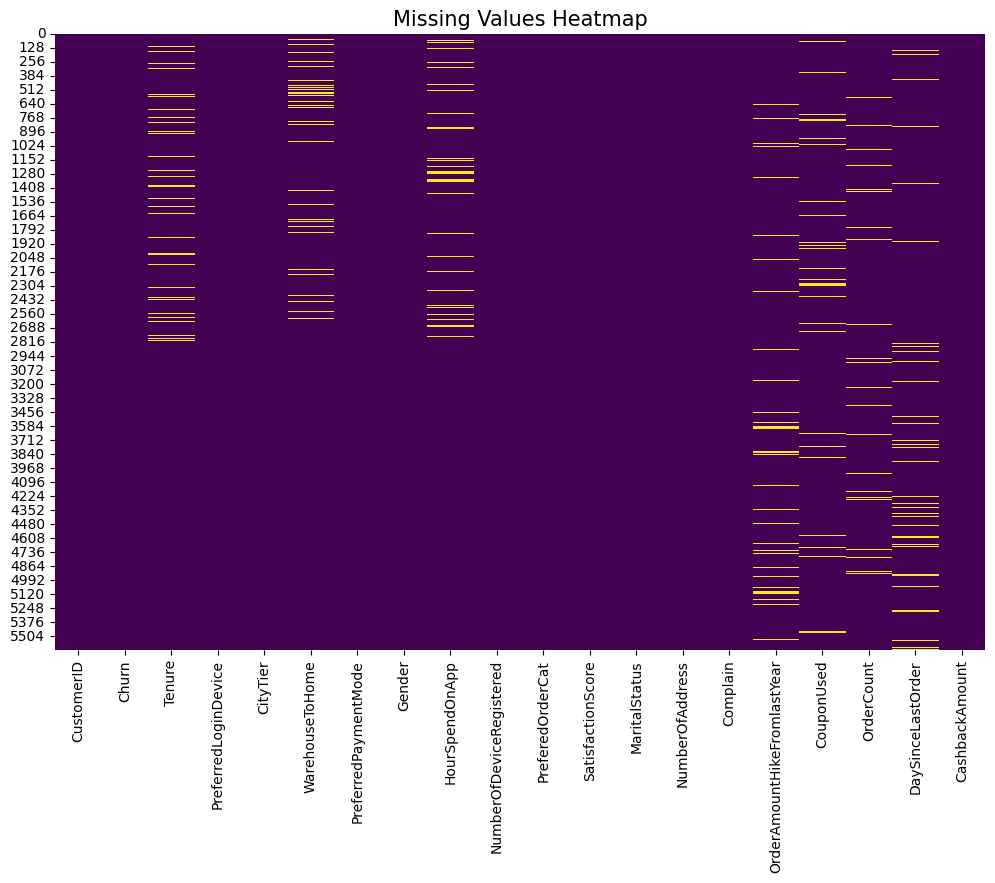


--- Distribution of Missing Values by Churn ---

Missing value distribution for "DaySinceLastOrder" by Churn:
Churn
0    5.403674
1    5.696203
dtype: float64

Chi-squared Test for "DaySinceLastOrder" Missingness: Chi2-statistic=0.080, p-value=0.777
Conclusion: The difference is not statistically significant. Missingness appears to be random with respect to churn.

Missing value distribution for "OrderAmountHikeFromlastYear" by Churn:
Churn
0    5.360957
1    1.476793
dtype: float64

Chi-squared Test for "OrderAmountHikeFromlastYear" Missingness: Chi2-statistic=25.658, p-value=0.000
Conclusion: The difference in missing values is statistically significant. Missingness is likely a signal for churn.

Missing value distribution for "Tenure" by Churn:
Churn
0    3.908586
1    8.544304
dtype: float64

Chi-squared Test for "Tenure" Missingness: Chi2-statistic=36.878, p-value=0.000
Conclusion: The difference in missing values is statistically significant. Missingness is likely a signal for c

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming df_ecommerce is your DataFrame
# Example: df_ecommerce = pd.read_csv('your_data_file.csv')

print("--- Starting Missing Values Analysis ---")

# Overall Missing Values
missing_data = df_ecommerce.isnull().sum()
total_rows = len(df_ecommerce)

missing_df = pd.DataFrame({
    'Total Missing': missing_data,
    'Percentage (%)': (missing_data / total_rows) * 100
}).sort_values(by='Percentage (%)', ascending=False)

columns_with_missing_data = missing_df[missing_df['Total Missing'] > 0]

print("\nOverall Missing values by column:")
print(columns_with_missing_data)

if not columns_with_missing_data.empty:
    print("\nColumns with missing values are:")
    print(columns_with_missing_data.index.tolist())
else:
    print("\nNo missing values found in the dataset.")

# Visualize missing data as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_ecommerce.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap', fontsize=15)
plt.show()

# Distribution and Statistical Test of Missing Values by Churn
if not columns_with_missing_data.empty:
    print("\n--- Distribution of Missing Values by Churn ---")
    for col in columns_with_missing_data.index:
        # Create a boolean column for missingness
        df_ecommerce[f'{col}_missing'] = df_ecommerce[col].isnull()
        
        # Create a contingency table
        contingency_table = pd.crosstab(df_ecommerce[f'{col}_missing'], df_ecommerce['Churn'])
        
        # Perform Chi-squared test
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

        # Print analysis
        missing_by_churn = df_ecommerce[df_ecommerce[col].isnull()].groupby('Churn').size()
        total_by_churn = df_ecommerce.groupby('Churn').size()
        
        missing_proportion_by_churn = (missing_by_churn / total_by_churn) * 100
        
        print(f'\nMissing value distribution for "{col}" by Churn:')
        print(missing_proportion_by_churn)
        
        print(f'\nChi-squared Test for "{col}" Missingness: Chi2-statistic={chi2:.3f}, p-value={p_value:.3f}')
        
        if p_value < 0.05:
            print('Conclusion: The difference in missing values is statistically significant. Missingness is likely a signal for churn.')
        else:
            print('Conclusion: The difference is not statistically significant. Missingness appears to be random with respect to churn.')
            
        # Clean up the temporary column
        df_ecommerce.drop(columns=[f'{col}_missing'], inplace=True)

print("-" * 50)

## 7.1. DaySinceLastOrder

In [ ]:
# Missing DaySinceLastOrder subset
missing_day_df = df_ecommerce[df_ecommerce['DaySinceLastOrder'].isna()]

analysis_missing_day = {
    "total_missing_day": len(missing_day_df),
    "with_orders": (missing_day_df['OrderCount'] > 0).sum(),
    "without_orders": (missing_day_df['OrderCount'] == 0).sum()
}

for k, v in analysis_missing_day.items():
    print(f"{k}:\n{v}\n")


total_missing_day:
307

with_orders:
307

without_orders:
0



Missing `DaySinceLastOrder` is random because `OrderCount` > 0 in last month means should have value between 0 to max 31

## 7.2. OrderCount

In [26]:
# Missing OrderCount subset
missing_order_count_df = df_ecommerce[df_ecommerce['OrderCount'].isna()]


analysis_missing_order_count = {
    "total_missing_order_count": len(missing_order_count_df),
    "with_coupon": (missing_order_count_df['CouponUsed'] > 0).sum(),
    "without_coupon": (missing_order_count_df['CouponUsed'] == 0).sum(),
    "with_day_last_order_in_a_month": (missing_order_count_df['DaySinceLastOrder'] < 32).sum(),
    "without_day_last_order_in_a_month": (missing_order_count_df['DaySinceLastOrder'] >= 32).sum()
}

for k, v in analysis_missing_order_count.items():
    print(f"{k}:\n{v}\n")

missing_order_count_df


total_missing_order_count:
258

with_coupon:
220

without_coupon:
38

with_day_last_order_in_a_month:
258

without_day_last_order_in_a_month:
0



CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  \
64         50065      0    24.0         Mobile Phone         1   
90         50091      0    14.0         Mobile Phone         3   
110        50111      0    16.0         Mobile Phone         3   
120        50121      0     4.0             Computer         1   
143        50144      0    18.0         Mobile Phone         1   
...          ...    ...     ...                  ...       ...   
5565       55566      0     5.0             Computer         1   
5581       55582      0    21.0             Computer         1   
5590       55591      0    12.0         Mobile Phone         1   
5621       55622      1    14.0         Mobile Phone         3   
5622       55623      0    13.0         Mobile Phone         3   

      WarehouseToHome PreferredPaymentMode  Gender  HourSpendOnApp  \
64                9.0          Credit Card  Female             3.0   
90               12.0           Debit Card  Female             3.0   
110              22.0             E wallet  Female             3.0   
120               9.0          Credit Card    Male             3.0   
143              26.0          Credit Card    Male             3.0   
...               ...                  ...     ...             ...   
5565             17.0          Credit Card  Female             3.0   
5581              8.0          Credit Card  Female             4.0   
5590             17.0          Credit Card  Female             4.0   
5621             35.0             E wallet    Male             3.0   
5622             31.0             E wallet  Female             3.0   

      NumberOfDeviceRegistered PreferedOrderCat  SatisfactionScore  \
64                           3          Grocery                  4   
90                           3          Fashion                  2   
110                          3          Grocery                  2   
120                          3          Fashion                  3   
143                          3          Grocery                  2   
...                        ...              ...                ...   
5565                         4          Fashion                  3   
5581                         4          Fashion                  4   
5590                         6          Fashion                  3   
5621                         5          Fashion                  5   
5622                         5          Grocery                  1   

     MaritalStatus  NumberOfAddress  Complain  OrderAmountHikeFromlastYear  \
64          Single                4         0                         18.0   
90          Single                4         1                         18.0   
110       Divorced                6         1                         22.0   
120        Married               10         0                         12.0   
143       Divorced                1         1                         14.0   
...            ...              ...       ...                          ...   
5565       Married                6         0                         21.0   
5581       Married                2         0                         19.0   
5590       Married                5         0                         13.0   
5621       Married                6         1                         14.0   
5622       Married                2         0                         12.0   

      CouponUsed  OrderCount  DaySinceLastOrder  CashbackAmount  
64           0.0         NaN                0.0          237.34  
90           0.0         NaN                0.0          235.91  
110          0.0         NaN                9.0          260.64  
120          1.0         NaN                2.0          236.75  
143          0.0         NaN               10.0          234.96  
...          ...         ...                ...             ...  
5565         4.0         NaN                9.0          235.31  
5581         1.0         NaN               13.0          244.57  


Missing `OrderCount` is random because at least should have value > 0 since `DaySinceLastOrder` present

## 7.3. CouponUsed

In [ ]:
# Missing CouponUsed subset
missing_CouponUsed_df = df_ecommerce[df_ecommerce['CouponUsed'].isna()]

missing_CouponUsed_df


CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  \
61         50062      0    13.0         Mobile Phone         1   
62         50063      0    28.0         Mobile Phone         1   
69         50070      0    18.0             Computer         1   
112        50113      0    25.0             Computer         3   
138        50139      0    19.0         Mobile Phone         3   
...          ...    ...     ...                  ...       ...   
5354       55355      0    21.0         Mobile Phone         3   
5355       55356      0    23.0         Mobile Phone         1   
5461       55462      0    31.0             Computer         3   
5470       55471      0    31.0             Computer         1   
5592       55593      0    11.0         Mobile Phone         1   

      WarehouseToHome PreferredPaymentMode  Gender  HourSpendOnApp  \
61               10.0          Credit Card  Female             2.0   
62               20.0          Credit Card    Male             3.0   
69                8.0          Credit Card    Male             3.0   
112               8.0           Debit Card    Male             3.0   
138               8.0     Cash on Delivery  Female             3.0   
...               ...                  ...     ...             ...   
5354              9.0           Debit Card  Female             3.0   
5355              8.0           Debit Card    Male             3.0   
5461              9.0          Credit Card    Male             3.0   
5470             22.0           Debit Card    Male             3.0   
5592             17.0           Debit Card  Female             3.0   

      NumberOfDeviceRegistered PreferedOrderCat  SatisfactionScore  \
61                           3           Others                  3   
62                           2           Others                  4   
69                           4          Grocery                  2   
112                          4           Others                  3   
138                          5          Grocery                  4   
...                        ...              ...                ...   
5354                         2          Grocery                  4   
5355                         4          Grocery                  3   
5461                         4          Grocery                  4   
5470                         4          Grocery                  3   
5592                         2          Fashion                  1   

     MaritalStatus  NumberOfAddress  Complain  OrderAmountHikeFromlastYear  \
61        Divorced                2         0                         14.0   
62          Single                9         0                         11.0   
69        Divorced               10         0                         23.0   
112         Single                2         1                         18.0   
138       Divorced                4         1                         12.0   
...            ...              ...       ...                          ...   
5354       Married                8         0                         15.0   
5355        Single                6         0                         15.0   
5461       Married                6         0                         23.0   
5470       Married                4         1                         15.0   
5592       Married                3         1                         26.0   

      CouponUsed  OrderCount  DaySinceLastOrder  CashbackAmount  
61           NaN         9.0                9.0          290.33  
62           NaN         2.0               15.0          287.22  
69           NaN        11.0                8.0          267.92  
112          NaN        15.0               12.0          290.68  
138          NaN         7.0                7.0          268.72  
...          ...         ...                ...             ...  
5354         NaN         2.0                3.0          284.72  
5355         NaN         2.0                1.0          278.79  


## 7.4 Tenure

In [29]:
df_ecommerce[df_ecommerce['Tenure'] == 0][['OrderAmountHikeFromlastYear', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']]

OrderAmountHikeFromlastYear  OrderCount  DaySinceLastOrder  \
3                            23.0         1.0                3.0   
4                            11.0         1.0                3.0   
5                            22.0         6.0                7.0   
12                           13.0         2.0                2.0   
13                           17.0         1.0                0.0   
...                           ...         ...                ...   
2778                         22.0         1.0                4.0   
2781                         11.0         1.0                2.0   
2787                         14.0         2.0                2.0   
2809                         18.0         1.0                0.0   
2812                         20.0         1.0                3.0   

      CashbackAmount  
3             134.07  
4             129.60  
5             139.19  
12            134.41  
13            133.88  
...              ...  
2778          149.07  
2781          123.80  
2787          147.87  
2809          129.66  
2812          161.42  

[508 rows x 4 columns]

In [28]:
missing_tenure_df = df_ecommerce[df_ecommerce['Tenure'].isna()]
missing_tenure_df

CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  \
1          50002      1     NaN         Mobile Phone         1   
2          50003      1     NaN         Mobile Phone         1   
6          50007      1     NaN         Mobile Phone         3   
7          50008      1     NaN         Mobile Phone         1   
9          50010      1     NaN         Mobile Phone         1   
...          ...    ...     ...                  ...       ...   
2756       52757      0     NaN         Mobile Phone         2   
2760       52761      0     NaN             Computer         1   
2773       52774      0     NaN         Mobile Phone         3   
2783       52784      1     NaN             Computer         3   
2802       52803      0     NaN         Mobile Phone         1   

      WarehouseToHome PreferredPaymentMode  Gender  HourSpendOnApp  \
1                 8.0                  UPI    Male             3.0   
2                30.0           Debit Card    Male             2.0   
6                11.0     Cash on Delivery    Male             2.0   
7                 6.0          Credit Card    Male             3.0   
9                31.0           Debit Card    Male             2.0   
...               ...                  ...     ...             ...   
2756              8.0                  UPI  Female             2.0   
2760              7.0          Credit Card    Male             2.0   
2773              7.0          Credit Card    Male             3.0   
2783             15.0             E wallet    Male             2.0   
2802              8.0          Credit Card  Female             3.0   

      NumberOfDeviceRegistered    PreferedOrderCat  SatisfactionScore  \
1                            4        Mobile Phone                  3   
2                            4        Mobile Phone                  3   
6                            3  Laptop & Accessory                  2   
7                            3        Mobile Phone                  2   
9                            5        Mobile Phone                  3   
...                        ...                 ...                ...   
2756                         3        Mobile Phone                  4   
2760                         4        Mobile Phone                  3   
2773                         4        Mobile Phone                  4   
2783                         3        Mobile Phone                  5   
2802                         3        Mobile Phone                  3   

     MaritalStatus  NumberOfAddress  Complain  OrderAmountHikeFromlastYear  \
1           Single                7         1                         15.0   
2           Single                6         1                         14.0   
6         Divorced                4         0                         14.0   
7         Divorced                3         1                         16.0   
9           Single                2         0                         12.0   
...            ...              ...       ...                          ...   
2756       Married                5         0                         14.0   
2760       Married                2         0                         12.0   
2773       Married                1         0                         14.0   
2783       Married                2         0                         19.0   
2802       Married                3         0                         14.0   

      CouponUsed  OrderCount  DaySinceLastOrder  CashbackAmount  
1            0.0         1.0                0.0          120.90  
2            0.0         1.0                3.0          120.28  
6            0.0         1.0                0.0          120.86  
7            2.0         2.0                0.0          122.93  
9            1.0         1.0                1.0          122.93  
...          ...         ...                ...             ...  
2756         0.0         1.0                2.0          121.87  
2760         0.0         1.0  

## 8. Multicollinearity and Correlation

--- Correlation Analysis (Spearman Method) ---


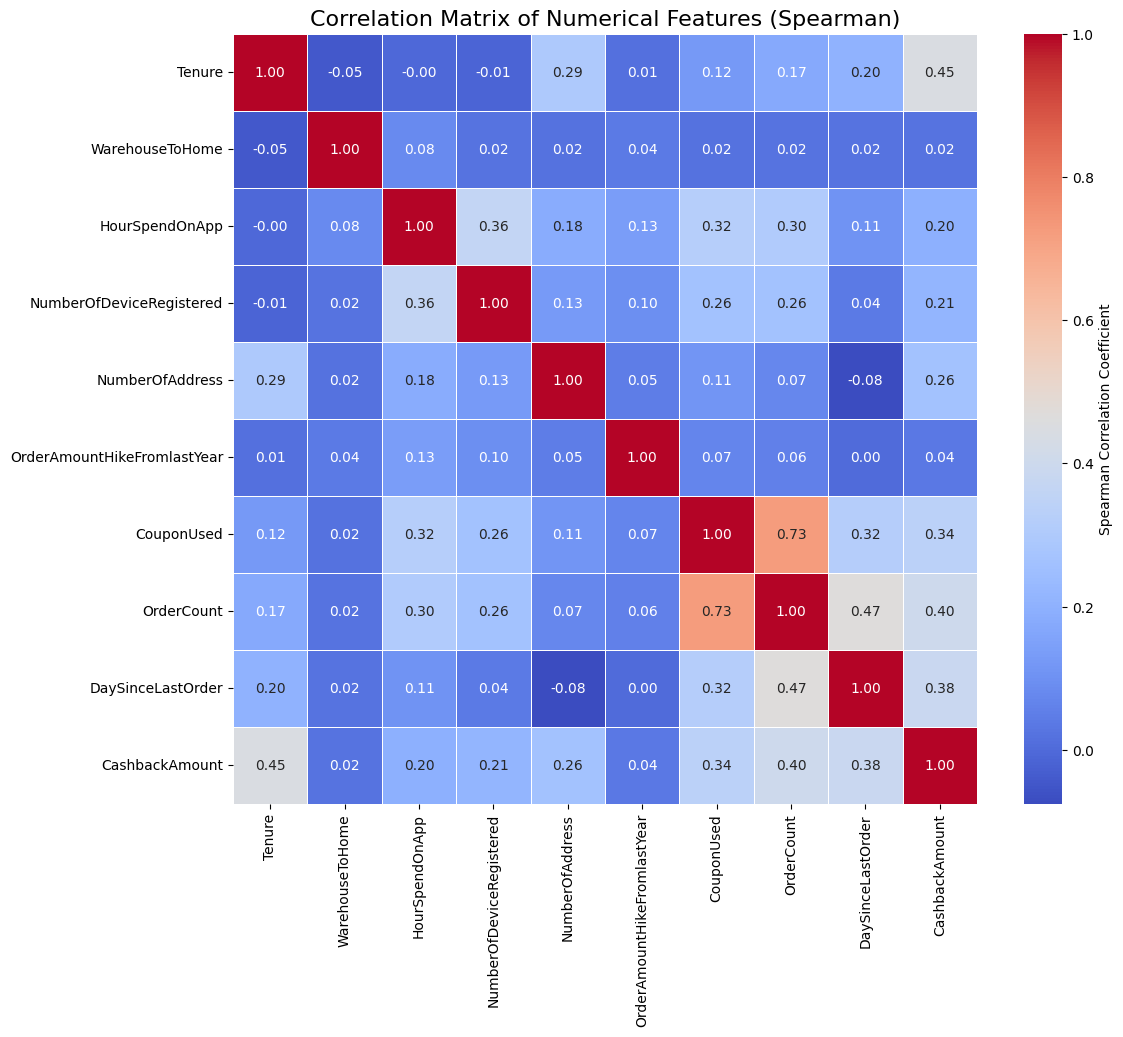


--- Multicollinearity Analysis with VIF ---
                       feature        VIF
9               CashbackAmount  31.054016
2               HourSpendOnApp  19.558858
5  OrderAmountHikeFromlastYear  16.465731
3     NumberOfDeviceRegistered  15.542530
7                   OrderCount   5.746735
6                   CouponUsed   4.541017
1              WarehouseToHome   4.243046
4              NumberOfAddress   4.093194
8            DaySinceLastOrder   3.758446
0                       Tenure   2.570139

--- VIF Interpretation ---
VIF values:
- VIF = 1: No correlation between the feature and other features.
- 1 < VIF < 5: Moderate correlation.
- VIF >= 5: High correlation, which may be problematic.

--------------------------------------------------


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df_ecommerce is your DataFrame and you've already handled missing values

# We will use only the numerical features for this analysis
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# --- Correlation Matrix and Heatmap ---
print("--- Correlation Analysis (Spearman Method) ---")

# Calculate the correlation matrix using the Spearman method
corr_matrix = df_ecommerce[numerical_features].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'label': 'Spearman Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features (Spearman)', fontsize=16)
plt.show()

# --- Variance Inflation Factor (VIF) ---
# VIF measures multicollinearity. VIF > 5-10 is often a sign of high multicollinearity.
print("\n--- Multicollinearity Analysis with VIF ---")

# Drop rows with any missing values for VIF calculation
df_no_missing = df_ecommerce[numerical_features].dropna()

# Create a DataFrame to store VIF results
vif_data = pd.DataFrame()
vif_data["feature"] = df_no_missing.columns
vif_data["VIF"] = [variance_inflation_factor(df_no_missing.values, i) for i in range(df_no_missing.shape[1])]

# Sort VIF values in descending order
vif_data.sort_values(by='VIF', ascending=False, inplace=True)

print(vif_data)

# Interpret VIF results
print("\n--- VIF Interpretation ---")
print("VIF values:")
print("- VIF = 1: No correlation between the feature and other features.")
print("- 1 < VIF < 5: Moderate correlation.")
print("- VIF >= 5: High correlation, which may be problematic.")

print("\n" + "-" * 50)

# 9. Save Dataset

In [13]:
# df_ecommerce.to_csv('eda.csv', index=False)